### Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder, HashingEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, classification_report, accuracy_score
from sklearn.model_selection import learning_curve
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # S'assurer que numpy est importé
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
import os
import joblib

In [196]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

Fonction d'evaluation du modele : (metriques + courbe ROC)

In [197]:
def evaluate_model(X_train, y_test, y_pred, y_probs=None):
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    
 
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-depression', 'depression'], yticklabels=['Non-depression', 'depression'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
     
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
     
    if y_probs is not None:
        plt.figure(figsize=(6, 5))
        
        
        classes = np.unique(y_test)
        for idx, class_label in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test, y_probs[:, idx], pos_label=class_label)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()



### Présentation des données brutes

In [198]:
file_path = 'depression_dataset.csv' 
df = pd.read_csv(file_path)

In [199]:
df

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


In [200]:
print(f"\nDimensions du dataset: {df.shape}")


Dimensions du dataset: (27901, 18)


In [201]:
print("Informations générales sur le dataset :")
df.info()

Informations générales sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                

In [202]:
print("\nStatistiques descriptives (avant nettoyage):")
print(df.describe())


Statistiques descriptives (avant nettoyage):
                  id           Age  Academic Pressure  Work Pressure  \
count   27901.000000  27901.000000       27901.000000   27901.000000   
mean    70442.149421     25.822300           3.141214       0.000430   
std     40641.175216      4.905687           1.381465       0.043992   
min         2.000000     18.000000           0.000000       0.000000   
25%     35039.000000     21.000000           2.000000       0.000000   
50%     70684.000000     25.000000           3.000000       0.000000   
75%    105818.000000     30.000000           4.000000       0.000000   
max    140699.000000     59.000000           5.000000       5.000000   

               CGPA  Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count  27901.000000        27901.000000      27901.000000      27901.000000   
mean       7.656104            2.943837          0.000681          7.156984   
std        1.470707            1.361148          0.044394          3

In [203]:
original_columns = df.columns.tolist()

In [204]:
# Remplacer les espaces et caractères spéciaux par '_' et mettre en minuscule
df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]

In [205]:
# Gérer spécifiquement le '?' dans le nom de colonne
df.columns = df.columns.str.replace('_$', '', regex=True) # Enlever '_' à la fin
renamed_columns = df.columns.tolist()
print("\nNoms de colonnes nettoyés:")
for old, new in zip(original_columns, renamed_columns):
    if old != new:
        print(f"'{old}' -> '{new}'")


Noms de colonnes nettoyés:
'Gender' -> 'gender'
'Age' -> 'age'
'City' -> 'city'
'Profession' -> 'profession'
'Academic Pressure' -> 'academic_pressure'
'Work Pressure' -> 'work_pressure'
'CGPA' -> 'cgpa'
'Study Satisfaction' -> 'study_satisfaction'
'Job Satisfaction' -> 'job_satisfaction'
'Sleep Duration' -> 'sleep_duration'
'Dietary Habits' -> 'dietary_habits'
'Degree' -> 'degree'
'Have you ever had suicidal thoughts ?' -> 'have_you_ever_had_suicidal_thoughts'
'Work/Study Hours' -> 'work_study_hours'
'Financial Stress' -> 'financial_stress'
'Family History of Mental Illness' -> 'family_history_of_mental_illness'
'Depression' -> 'depression'


### Feature Selection/Engineering

pretaitemant des donnees du dataset



In [206]:
df = df.drop('id', axis=1)

In [207]:
df

,gender,age,city,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work_study_hours,financial_stress,family_history_of_mental_illness,depression
0,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


In [208]:
 
print(f"\nRecherche de placeholders comme '?'...")
placeholders_found = False
for col in df.columns:
    if df[col].astype(str).str.contains(r'\?', regex=True).any():
        print(f"Placeholder '?' trouvé dans la colonne: {col}")
        placeholders_found = True
        df[col] = df[col].replace('?', np.nan)

if not placeholders_found:
    print("Aucun placeholder '?' trouvé.")


Recherche de placeholders comme '?'...
Placeholder '?' trouvé dans la colonne: financial_stress


In [209]:
 
print(f"\nNombre de valeurs manquantes avant suppression:\n{df.isnull().sum()}")
nan_count_before = df.isnull().sum().sum()


Nombre de valeurs manquantes avant suppression:
gender                                 0
age                                    0
city                                   0
profession                             0
academic_pressure                      0
work_pressure                          0
cgpa                                   0
study_satisfaction                     0
job_satisfaction                       0
sleep_duration                         0
dietary_habits                         0
degree                                 0
have_you_ever_had_suicidal_thoughts    0
work_study_hours                       0
financial_stress                       3
family_history_of_mental_illness       0
depression                             0
dtype: int64


In [210]:
df_cleaned = df.dropna()
print(f"Dimensions après suppression des NaN: {df_cleaned.shape}")
nan_removed = nan_count_before - df_cleaned.isnull().sum().sum()
print(f"{nan_removed} lignes contenant des NaN ont été supprimées.")

Dimensions après suppression des NaN: (27898, 17)
3 lignes contenant des NaN ont été supprimées.


### Gestion des valeurs redondantes

In [211]:
duplicates_before = df_cleaned.duplicated().sum()
print(f"\nNombre de lignes dupliquées avant suppression: {duplicates_before}")


Nombre de lignes dupliquées avant suppression: 0


In [212]:
df_cleaned = df_cleaned.drop_duplicates()
print(f"Dimensions après suppression des doublons: {df_cleaned.shape}")
duplicates_removed = duplicates_before - df_cleaned.duplicated().sum()
print(f"{duplicates_removed} lignes dupliquées ont été supprimées.")

Dimensions après suppression des doublons: (27898, 17)
0 lignes dupliquées ont été supprimées.


In [213]:
numerical_cols_potential = ['age', 'academic_pressure', 'work_pressure', 'cgpa',
                           'study_satisfaction', 'job_satisfaction', 'work_study_hours',
                           'financial_stress']
print("\nConversion des colonnes numériques potentielles en float...")
for col in numerical_cols_potential:
    if col in df_cleaned.columns:
        try:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col])
            print(f"Colonne '{col}' convertie en numérique.")
        except ValueError as e:
            print(f"Erreur de conversion pour '{col}': {e}. La colonne sera peut-être traitée comme catégorielle.")

print("\nTypes de données après conversion:")
print(df_cleaned.dtypes)


Conversion des colonnes numériques potentielles en float...
Colonne 'age' convertie en numérique.
Colonne 'academic_pressure' convertie en numérique.
Colonne 'work_pressure' convertie en numérique.
Colonne 'cgpa' convertie en numérique.
Colonne 'study_satisfaction' convertie en numérique.
Colonne 'job_satisfaction' convertie en numérique.
Colonne 'work_study_hours' convertie en numérique.
Colonne 'financial_stress' convertie en numérique.

Types de données après conversion:
gender                                  object
age                                    float64
city                                    object
profession                              object
academic_pressure                      float64
work_pressure                          float64
cgpa                                   float64
study_satisfaction                     float64
job_satisfaction                       float64
sleep_duration                          object
dietary_habits                          object
deg


--- Visualisation des données AVANT suppression des outliers ---


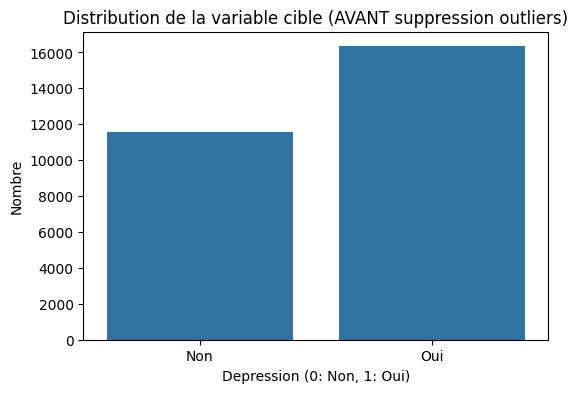


Histogrammes (AVANT suppression outliers) pour: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


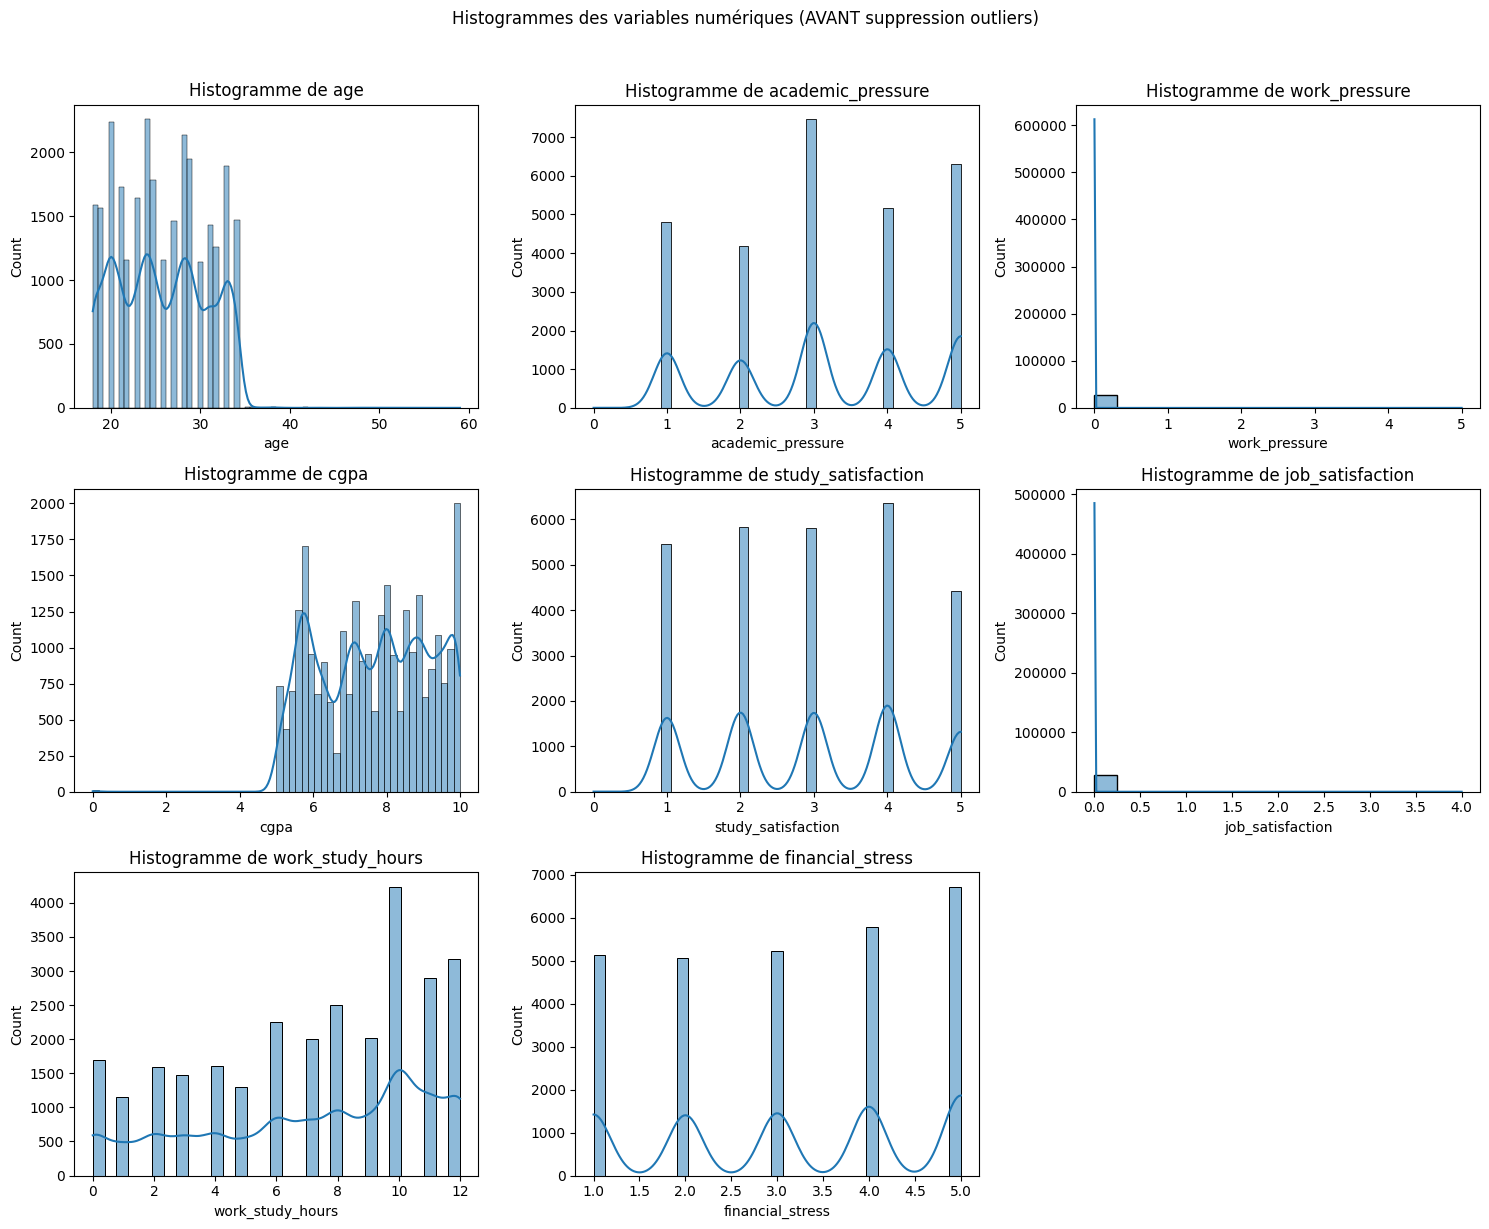


Boxplots (AVANT suppression outliers) pour: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


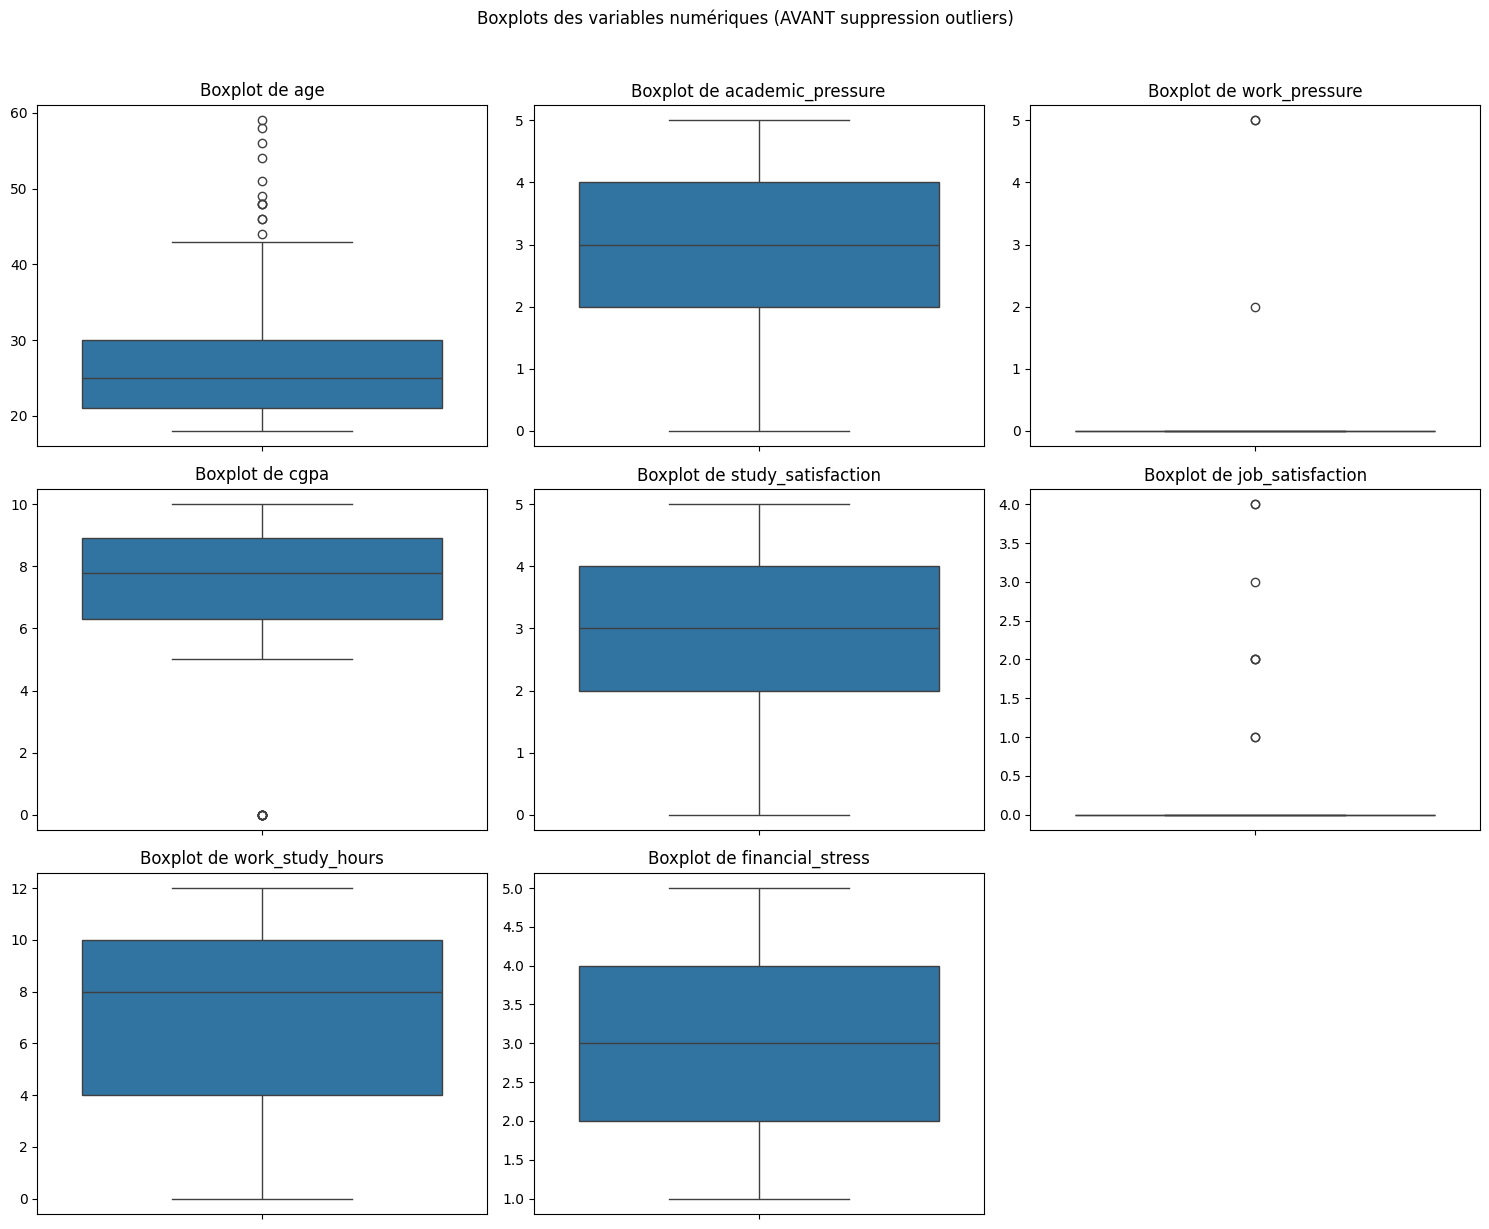


Diagrammes à barres (AVANT suppression outliers) pour: ['gender', 'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']


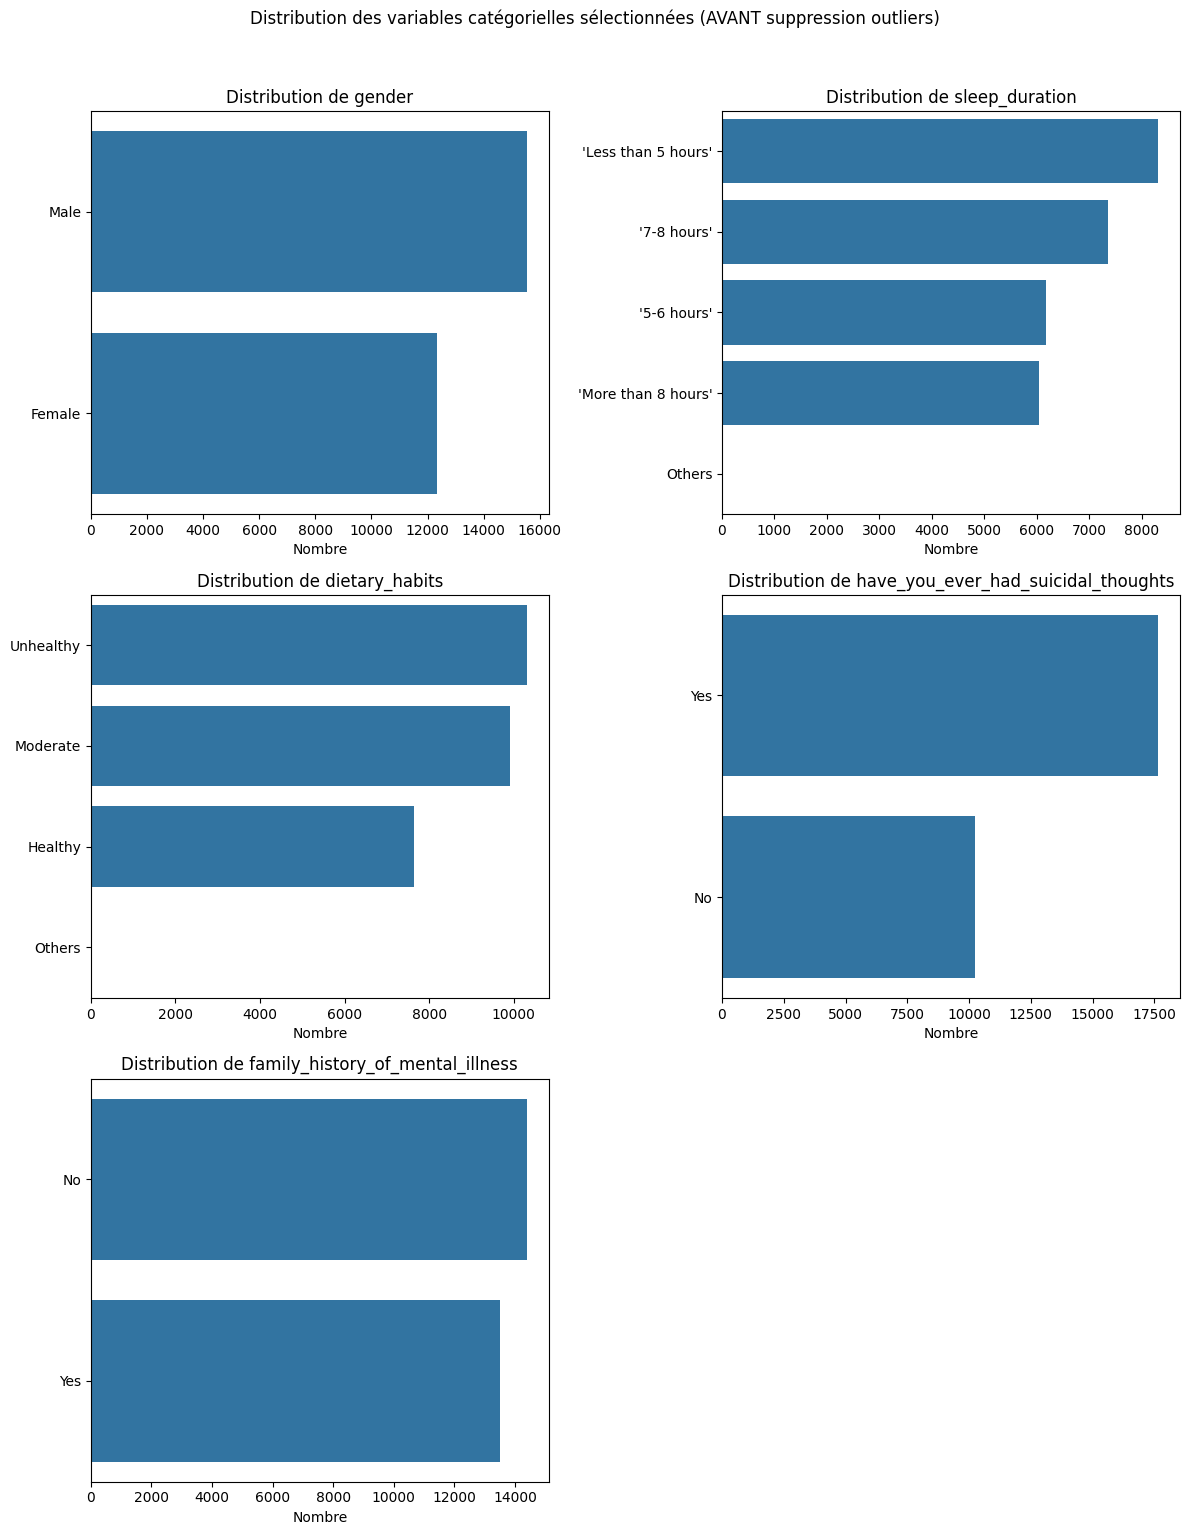


Heatmap de Corrélation (AVANT suppression outliers):


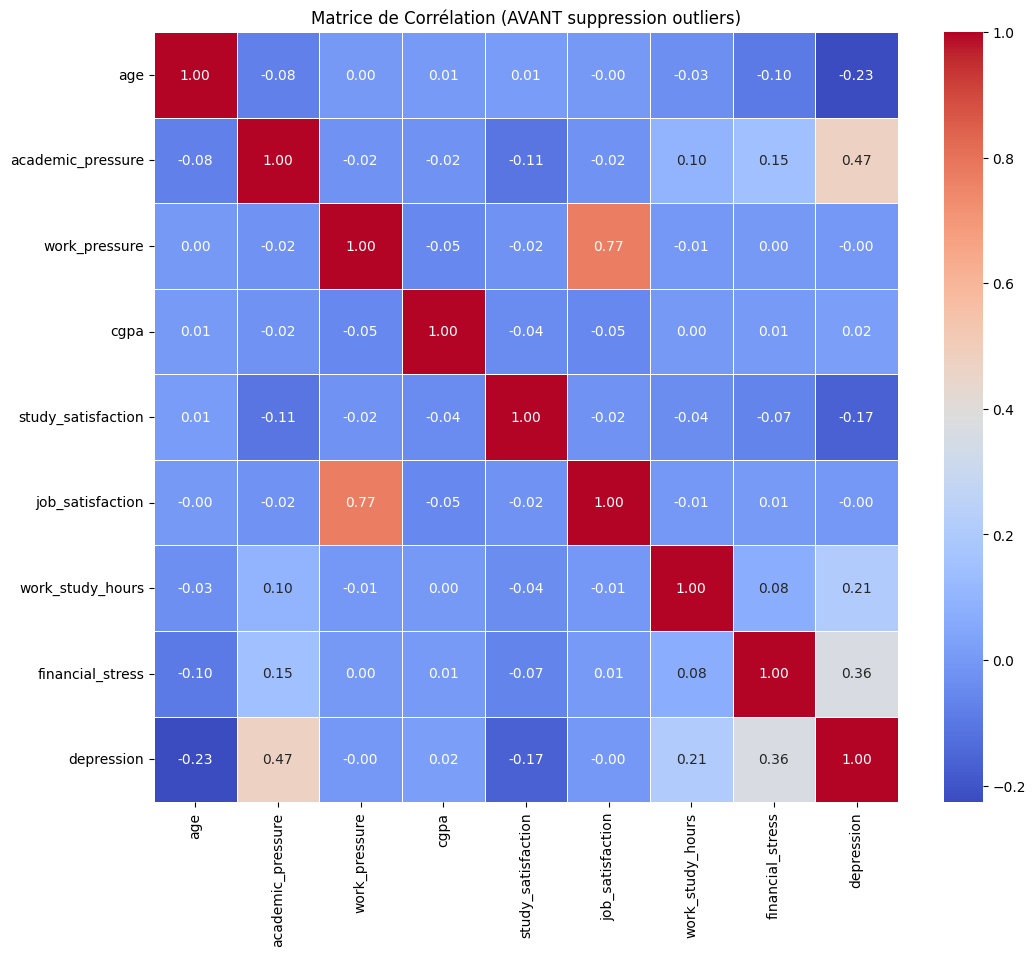


--- Fin des Visualisations Pré-Outliers ---


In [ ]:
# ***** DEBUT DU BLOC DE VISUALISATION A INSERER AVANT LA GESTION DES OUTLIERS *****

print("\n--- Visualisation des données AVANT suppression des outliers ---")

dataframe_to_visualize = df_cleaned 

if dataframe_to_visualize is not None and not dataframe_to_visualize.empty:

    # --- Distribution de la variable cible ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x='depression', data=dataframe_to_visualize)
    plt.title('Distribution de la variable cible (AVANT suppression outliers)')
    plt.xlabel('Depression (0: Non, 1: Oui)')
    plt.ylabel('Nombre')
    plt.xticks([0, 1], ['Non', 'Oui'])
    plt.show()

    # --- Histogrammes pour les variables numériques ---
    numerical_cols_plot = dataframe_to_visualize.select_dtypes(include=np.number).columns.tolist()
    if 'depression' in numerical_cols_plot:
        numerical_cols_plot.remove('depression')

    if numerical_cols_plot: # Vérifier s'il y a des colonnes numériques à tracer
        print(f"\nHistogrammes (AVANT suppression outliers) pour: {numerical_cols_plot}")
        n_cols_hist = 3
        n_rows_hist = (len(numerical_cols_plot) + n_cols_hist - 1) // n_cols_hist
        fig_hist, axes_hist = plt.subplots(n_rows_hist, n_cols_hist, figsize=(15, 4 * n_rows_hist))
        axes_hist = axes_hist.flatten()

        for i, col in enumerate(numerical_cols_plot):
            sns.histplot(dataframe_to_visualize[col], kde=True, ax=axes_hist[i])
            axes_hist[i].set_title(f'Histogramme de {col}')
        for j in range(i + 1, len(axes_hist)):
            fig_hist.delaxes(axes_hist[j])

        plt.suptitle('Histogrammes des variables numériques (AVANT suppression outliers)', y=1.02)
        plt.tight_layout()
        plt.show()

        print(f"\nBoxplots (AVANT suppression outliers) pour: {numerical_cols_plot}")
        n_cols_box = 3
        n_rows_box = (len(numerical_cols_plot) + n_cols_box - 1) // n_cols_box
        fig_box, axes_box = plt.subplots(n_rows_box, n_cols_box, figsize=(15, 4 * n_rows_box))
        axes_box = axes_box.flatten()

        for i, col in enumerate(numerical_cols_plot):
            sns.boxplot(y=dataframe_to_visualize[col], ax=axes_box[i])
            axes_box[i].set_title(f'Boxplot de {col}')
            axes_box[i].set_ylabel('')
        for j in range(i + 1, len(axes_box)):
            fig_box.delaxes(axes_box[j])

        plt.suptitle('Boxplots des variables numériques (AVANT suppression outliers)', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune colonne numérique trouvée pour les histogrammes/boxplots.")


    # --- Bar charts (Countplots) pour les variables catégorielles importantes ---
    categorical_cols_plot = ['gender', 'sleep_duration', 'dietary_habits',
                             'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']
    categorical_cols_plot = [col for col in categorical_cols_plot if col in dataframe_to_visualize.columns]

    if categorical_cols_plot: 
        print(f"\nDiagrammes à barres (AVANT suppression outliers) pour: {categorical_cols_plot}")
        n_cols_cat = 2
        n_rows_cat = (len(categorical_cols_plot) + n_cols_cat - 1) // n_cols_cat
        fig_cat, axes_cat = plt.subplots(nrows=n_rows_cat, ncols=n_cols_cat, figsize=(12, 5 * n_rows_cat))
        axes_cat = axes_cat.flatten()

        for i, col in enumerate(categorical_cols_plot):
            sns.countplot(y=col, data=dataframe_to_visualize, ax=axes_cat[i], order = dataframe_to_visualize[col].value_counts().index)
            axes_cat[i].set_title(f'Distribution de {col}')
            axes_cat[i].set_xlabel('Nombre')
            axes_cat[i].set_ylabel('')
        for j in range(i + 1, len(axes_cat)):
            fig_cat.delaxes(axes_cat[j])

        plt.suptitle('Distribution des variables catégorielles sélectionnées (AVANT suppression outliers)', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("\nAucune colonne catégorielle spécifiée trouvée pour les diagrammes à barres.")

    # --- Matrice de corrélation (Heatmap) ---
    print("\nHeatmap de Corrélation (AVANT suppression outliers):")
    plt.figure(figsize=(12, 10))
    numerical_cols_corr = dataframe_to_visualize.select_dtypes(include=np.number).columns.tolist()
    if not numerical_cols_corr:
        print("Aucune colonne numérique trouvée pour la matrice de corrélation.")
    else:
        correlation_matrix = dataframe_to_visualize[numerical_cols_corr].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matrice de Corrélation (AVANT suppression outliers)')
        plt.show()

    print("\n--- Fin des Visualisations Pré-Outliers ---")

else:
    print("Le DataFrame 'df_cleaned' n'est pas disponible ou est vide. Impossible de générer les visualisations.")

# ***** FIN DU BLOC DE VISUALISATION *****



### Gestion des outliers

In [215]:
print("\nSuppression des outliers (méthode IQR)...")
numerical_cols_confirmed = df_cleaned.select_dtypes(include=np.number).columns.tolist()


Suppression des outliers (méthode IQR)...


In [216]:
if 'depression' in numerical_cols_confirmed:
    numerical_cols_confirmed.remove('depression')

print(f"Colonnes numériques pour détection d'outliers: {numerical_cols_confirmed}")

df_no_outliers = df_cleaned.copy()
outliers_removed_total = 0
initial_rows_outlier = df_no_outliers.shape[0]

for col in numerical_cols_confirmed:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compter les outliers avant de supprimer
    outliers_count = df_no_outliers[(df_no_outliers[col] < lower_bound) | (df_no_outliers[col] > upper_bound)].shape[0]
    if outliers_count > 0:
         print(f"  - {outliers_count} outliers détectés dans '{col}'")
    # Supprimer les outliers
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

rows_after_outlier = df_no_outliers.shape[0]
outliers_removed_total = initial_rows_outlier - rows_after_outlier

print(f"\nNombre total de lignes supprimées à cause des outliers: {outliers_removed_total}")
print(f"Dimensions après suppression des outliers: {df_no_outliers.shape}")

Colonnes numériques pour détection d'outliers: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']
  - 12 outliers détectés dans 'age'
  - 3 outliers détectés dans 'work_pressure'
  - 6 outliers détectés dans 'cgpa'
  - 2 outliers détectés dans 'job_satisfaction'

Nombre total de lignes supprimées à cause des outliers: 23
Dimensions après suppression des outliers: (27875, 17)


In [217]:
df_processed = df_no_outliers.copy()

Vérification les valeurs uniques des colonnes catégorielles importantes

In [ ]:

print("\nValeurs uniques dans certaines colonnes catégorielles (après nettoyage):")
categorical_cols_check = ['gender', 'sleep_duration', 'dietary_habits', 'degree',
                          'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']
for col in categorical_cols_check:
     if col in df_processed.columns:
        print(f"{col}: {df_processed[col].unique()}")


Valeurs uniques dans certaines colonnes catégorielles (après nettoyage):
gender: ['Male' 'Female']
sleep_duration: ["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']
dietary_habits: ['Healthy' 'Moderate' 'Unhealthy' 'Others']
degree: ['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' "'Class 12'" 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others']
have_you_ever_had_suicidal_thoughts: ['Yes' 'No']
family_history_of_mental_illness: ['No' 'Yes']


### Statistiques et Visualisations

Génération des visualisations pour le dataset prétraité...


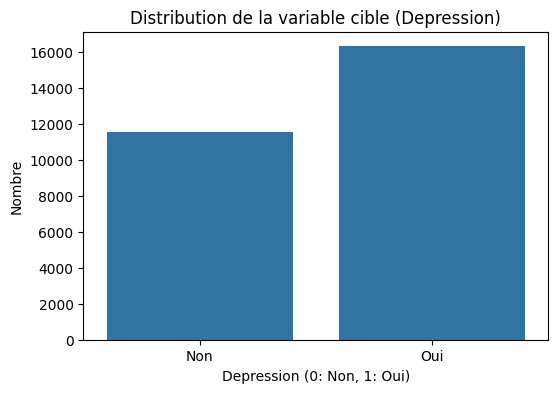


Histogrammes pour: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


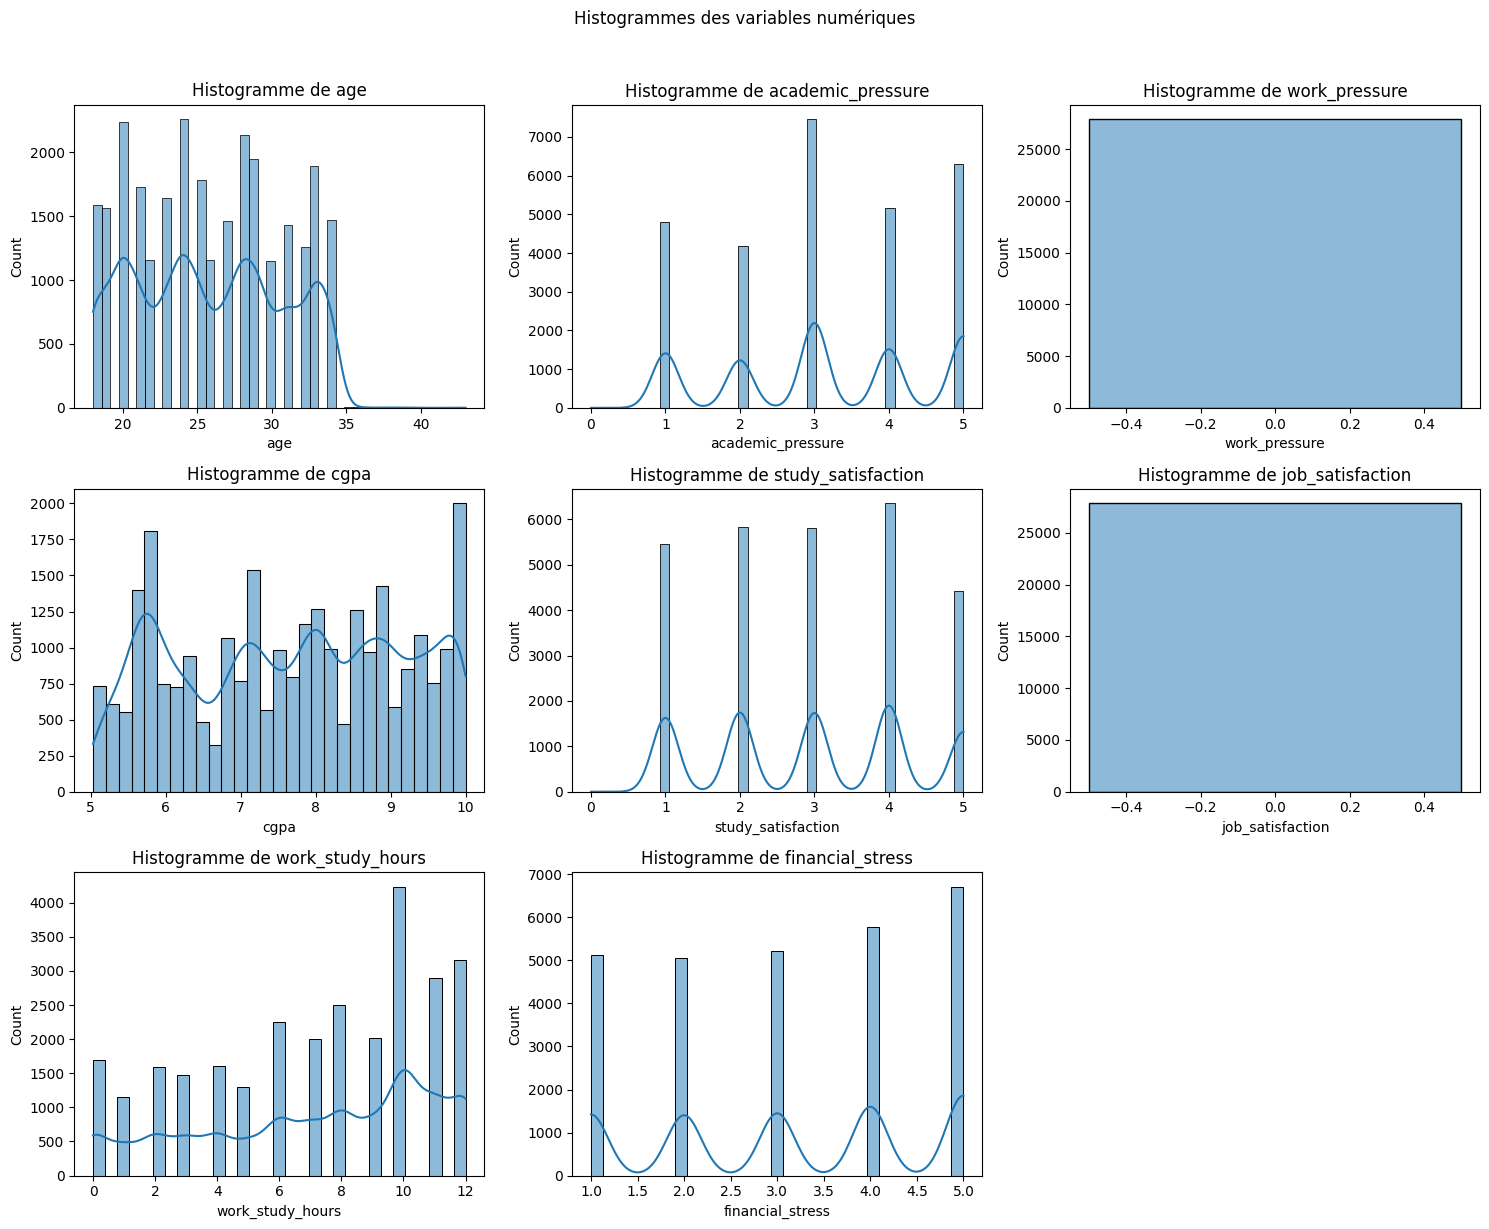


Boxplots pour: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


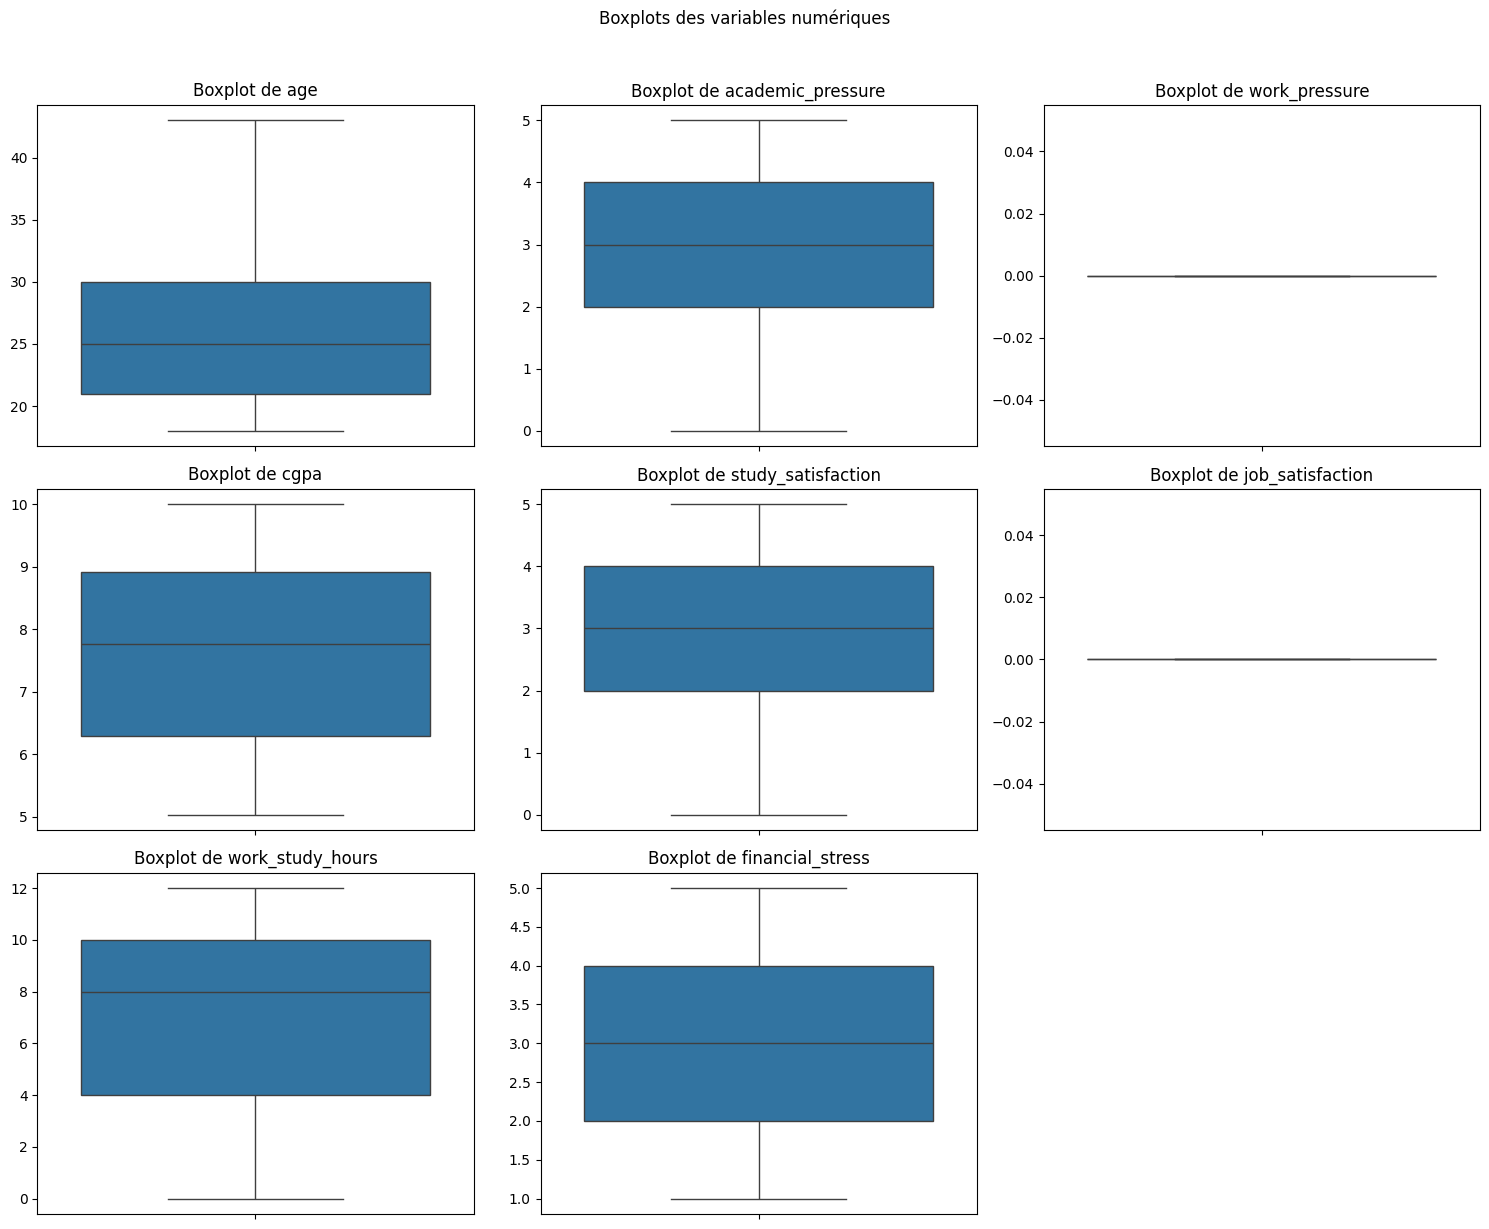


Diagrammes à barres pour: ['gender', 'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']


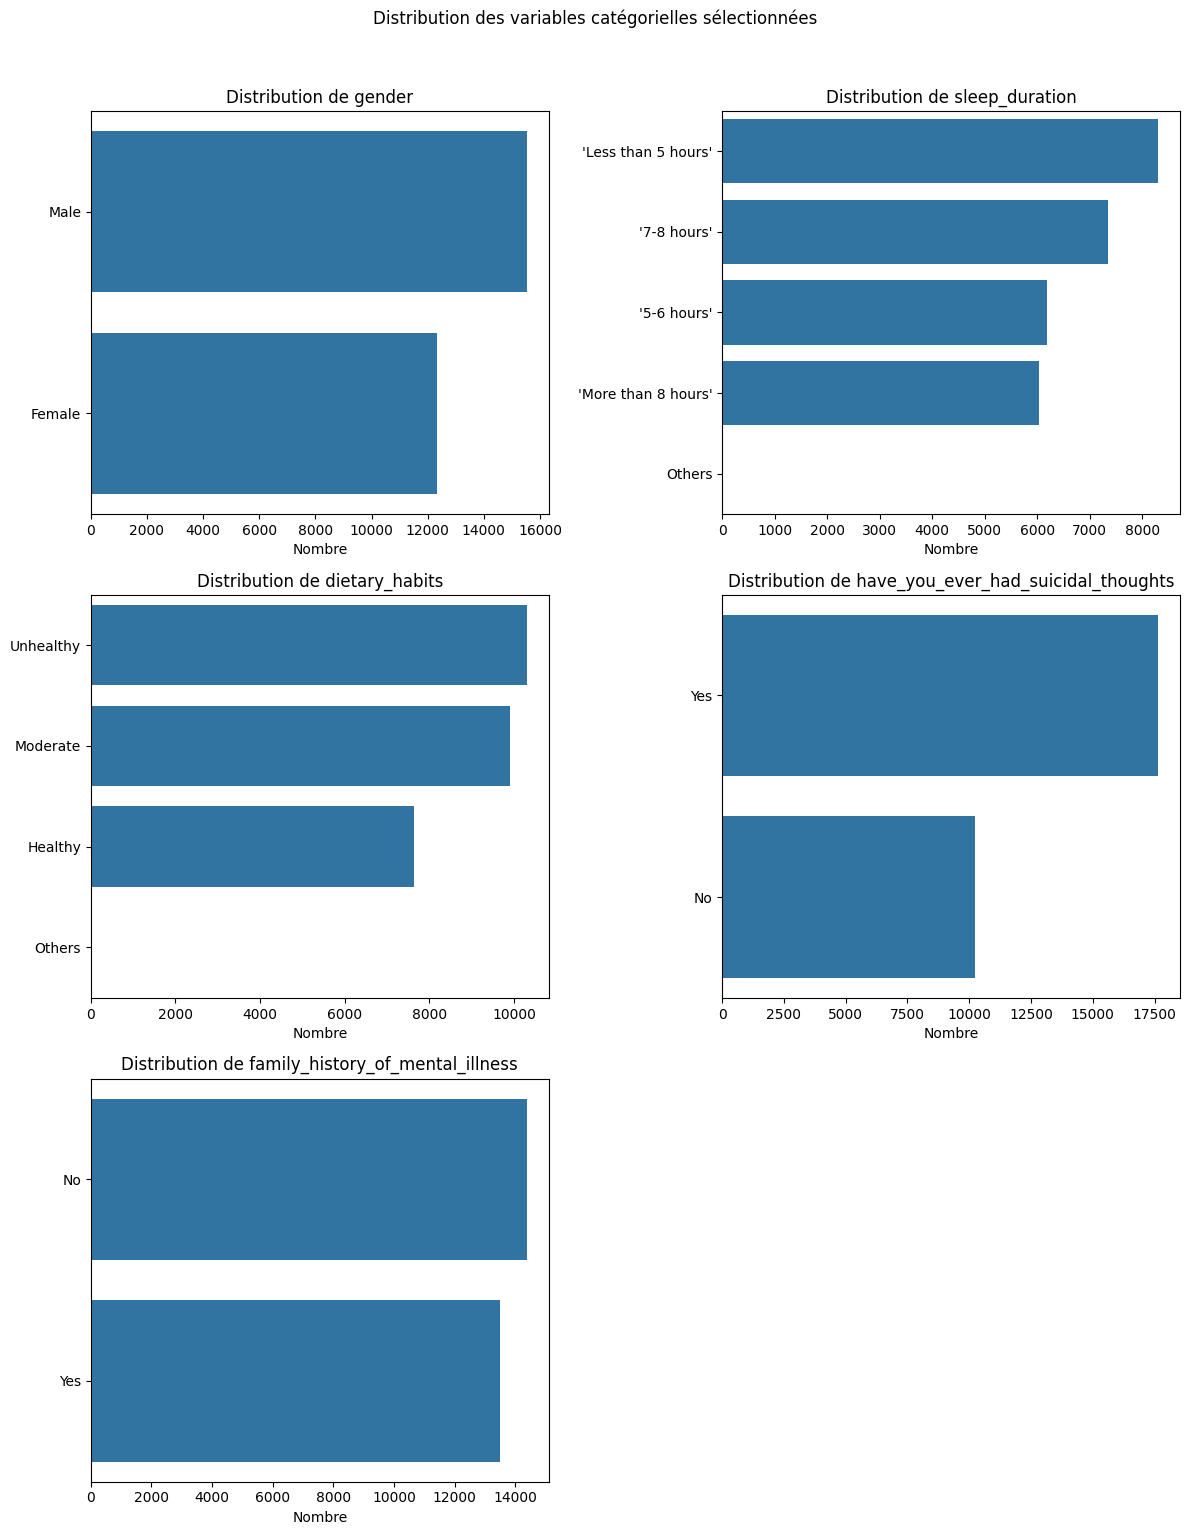


Heatmap de Corrélation des variables numériques:


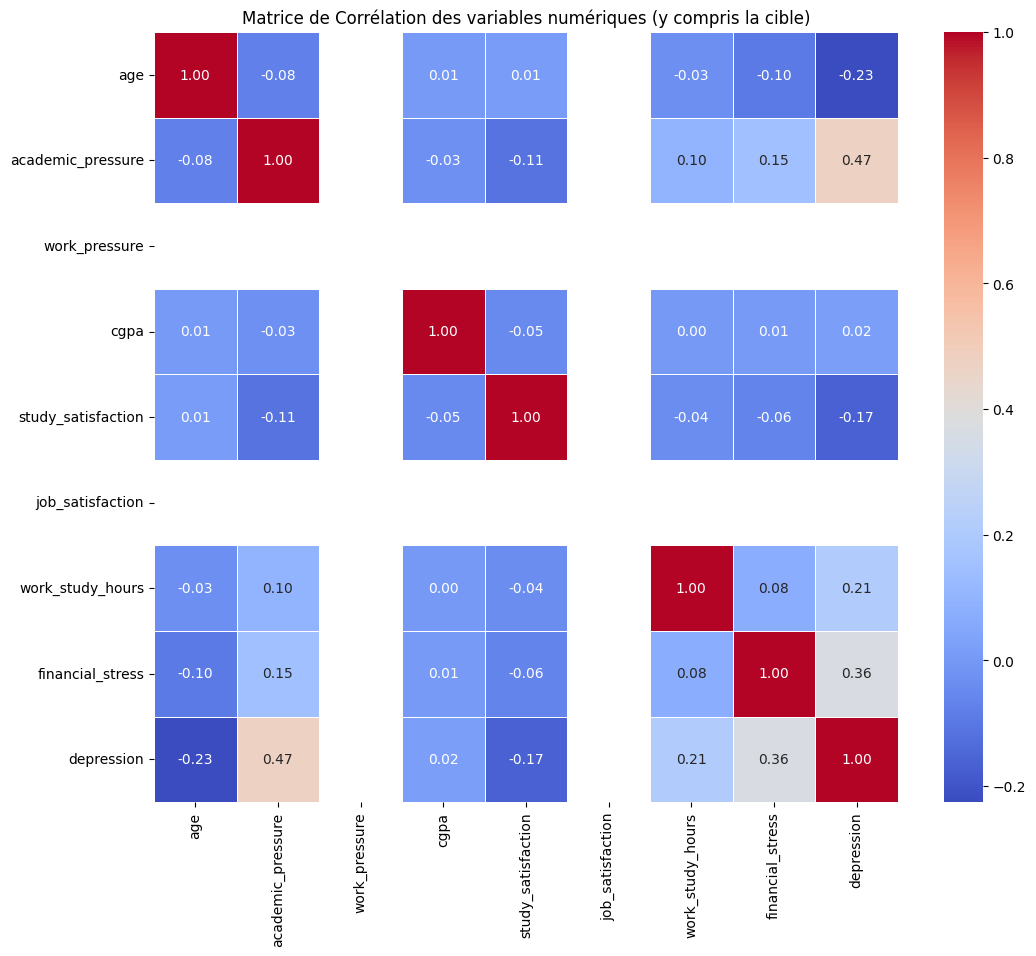


--- Fin des Visualisations ---


In [ ]:

if 'df_processed' not in locals():
    print("Erreur : Le DataFrame 'df_processed' n'a pas été trouvé. Veuillez exécuter la cellule de prétraitement (Cellule 4) d'abord.")
else:
    print("Génération des visualisations pour le dataset prétraité...")

    # --- Distribution de la variable cible ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x='depression', data=df_processed)
    plt.title('Distribution de la variable cible (Depression)')
    plt.xlabel('Depression (0: Non, 1: Oui)')
    plt.ylabel('Nombre')
    plt.xticks([0, 1], ['Non', 'Oui'])
    plt.show()

    # --- Histogrammes pour les variables numériques ---
    numerical_cols_plot = df_processed.select_dtypes(include=np.number).columns.tolist()
    if 'depression' in numerical_cols_plot:
        numerical_cols_plot.remove('depression') # Exclure la cible des histogrammes/boxplots séparés

    print(f"\nHistogrammes pour: {numerical_cols_plot}")
    n_cols_hist = 3 # Nombre de colonnes pour l'affichage des histogrammes
    n_rows_hist = (len(numerical_cols_plot) + n_cols_hist - 1) // n_cols_hist # Calculer le nombre de lignes nécessaires
    fig_hist, axes_hist = plt.subplots(n_rows_hist, n_cols_hist, figsize=(15, 4 * n_rows_hist))
    axes_hist = axes_hist.flatten() # Aplatir pour itérer facilement

    for i, col in enumerate(numerical_cols_plot):
        sns.histplot(df_processed[col], kde=True, ax=axes_hist[i])
        axes_hist[i].set_title(f'Histogramme de {col}')
    # Cacher les axes vides s'il y en a
    for j in range(i + 1, len(axes_hist)):
        fig_hist.delaxes(axes_hist[j])

    plt.suptitle('Histogrammes des variables numériques', y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Boxplots pour les variables numériques ---
    print(f"\nBoxplots pour: {numerical_cols_plot}")
    n_cols_box = 3 # Nombre de colonnes pour l'affichage des boxplots
    n_rows_box = (len(numerical_cols_plot) + n_cols_box - 1) // n_cols_box # Calculer le nombre de lignes nécessaires
    fig_box, axes_box = plt.subplots(n_rows_box, n_cols_box, figsize=(15, 4 * n_rows_box))
    axes_box = axes_box.flatten() # Aplatir pour itérer facilement

    for i, col in enumerate(numerical_cols_plot):
        sns.boxplot(y=df_processed[col], ax=axes_box[i])
        axes_box[i].set_title(f'Boxplot de {col}')
        axes_box[i].set_ylabel('') # Optionnel: enlever le nom de la colonne comme ylabel

    # Cacher les axes vides s'il y en a
    for j in range(i + 1, len(axes_box)):
        fig_box.delaxes(axes_box[j])

    plt.suptitle('Boxplots des variables numériques', y=1.02)
    plt.tight_layout()
    plt.show()


    # --- Bar charts (Countplots) pour les variables catégorielles importantes ---
    categorical_cols_plot = ['gender', 'sleep_duration', 'dietary_habits',
                             'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']
    # Filtrer au cas où une colonne n'existerait pas dans df_processed
    categorical_cols_plot = [col for col in categorical_cols_plot if col in df_processed.columns]

    print(f"\nDiagrammes à barres pour: {categorical_cols_plot}")
    n_cols_cat = 2 # Nombre de colonnes pour l'affichage
    n_rows_cat = (len(categorical_cols_plot) + n_cols_cat - 1) // n_cols_cat
    fig_cat, axes_cat = plt.subplots(nrows=n_rows_cat, ncols=n_cols_cat, figsize=(12, 5 * n_rows_cat)) # Ajuster la disposition
    axes_cat = axes_cat.flatten() # Aplatir

    for i, col in enumerate(categorical_cols_plot):
        sns.countplot(y=col, data=df_processed, ax=axes_cat[i], order = df_processed[col].value_counts().index)
        axes_cat[i].set_title(f'Distribution de {col}')
        axes_cat[i].set_xlabel('Nombre')
        axes_cat[i].set_ylabel('') # Enlever le nom de colonne comme ylabel

    # Cacher les axes vides
    for j in range(i + 1, len(axes_cat)):
        fig_cat.delaxes(axes_cat[j])

    plt.suptitle('Distribution des variables catégorielles sélectionnées', y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Matrice de corrélation (Heatmap) ---
    print("\nHeatmap de Corrélation des variables numériques:")
    plt.figure(figsize=(12, 10))
    # Inclure la cible 'depression' si elle est numérique pour voir ses corrélations
    numerical_cols_corr = df_processed.select_dtypes(include=np.number).columns.tolist()
    if not numerical_cols_corr:
        print("Aucune colonne numérique trouvée pour la matrice de corrélation.")
    else:
        correlation_matrix = df_processed[numerical_cols_corr].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matrice de Corrélation des variables numériques (y compris la cible)')
        plt.show()

    print("\n--- Fin des Visualisations ---")

### Encodage des données catégorielles

In [220]:
# Séparer les features (X) et la target (y) du df_processed
target_column = 'depression'
if target_column not in df_processed.columns:
    raise ValueError(f"La colonne cible '{target_column}' n'existe pas dans le DataFrame traité.")

X = df_processed.drop(target_column, axis=1)
y = df_processed[target_column]

In [221]:
 
excluded_cols = ['city', 'profession', 'degree']
categorical_features_all = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_features_all if col not in excluded_cols]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()

In [222]:

overlapping_cols = set(categorical_features) & set(numerical_features)
if overlapping_cols:
    print(f"Attention: Colonnes à la fois numériques et catégorielles: {overlapping_cols}")
    # Décider comment les traiter, ici on les retire du set numérique par défaut
    numerical_features = [col for col in numerical_features if col not in overlapping_cols]


In [223]:
print(f"\nFeatures catégorielles à encoder: {categorical_features}")
print(f"Features numériques à normaliser: {numerical_features}")
print(f"Features exclues pour l'instant: {excluded_cols}")
print(f"Variable Cible: {target_column}")

 
print("\nPréparation pour l'encodage et la normalisation terminée.")


Features catégorielles à encoder: ['gender', 'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']
Features numériques à normaliser: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']
Features exclues pour l'instant: ['city', 'profession', 'degree']
Variable Cible: depression

Préparation pour l'encodage et la normalisation terminée.


### Définition des modèles et de leurs paramètres

In [224]:

models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42)
}


params = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100], # Réduire pour aller plus vite
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_split': [2, 5]
    },
    'SVC': {
        'classifier__C': [0.1, 1], # Réduire pour aller plus vite
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf'] # 'linear' peut être long
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 5, 7],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__subsample": [0.8, 1.0]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 63],
        'classifier__min_child_samples': [20, 50]
    },
    'HistGradientBoosting': {
        'classifier__max_iter': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__min_samples_leaf': [20, 50]
    }
    
}

print("Modèles et grilles de paramètres définis pour GridSearchCV.")

Modèles et grilles de paramètres définis pour GridSearchCV.


### Division des données (Train/Test Split)

In [225]:

X = df_processed.drop(target_column, axis=1)
y = df_processed[target_column]

cols_to_drop_for_training = ['city', 'profession', 'degree', 'work_pressure', 'job_satisfaction']
X_train_ready = X.drop(columns=[col for col in cols_to_drop_for_training if col in X.columns])

print(f"Colonnes utilisées pour l'entraînement: {X_train_ready.columns.tolist()}")


X_train, X_test, y_train, y_test = train_test_split(X_train_ready, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTaille de l'ensemble d'entraînement: {X_train.shape}, {y_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}, {y_test.shape}")

Colonnes utilisées pour l'entraînement: ['gender', 'age', 'academic_pressure', 'cgpa', 'study_satisfaction', 'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts', 'work_study_hours', 'financial_stress', 'family_history_of_mental_illness']

Taille de l'ensemble d'entraînement: (22300, 11), (22300,)
Taille de l'ensemble de test: (5575, 11), (5575,)


### Normalisation et Encodage (Définition du Pipeline)

In [ ]:
 
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numériques pour le pipeline: {numerical_features}")
print(f"Features catégorielles pour le pipeline: {categorical_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)],
    remainder='passthrough')

print("\nPréprocesseur (StandardScaler + OneHotEncoder) défini pour l'intégration dans le Pipeline.")
print("La normalisation et l'encodage seront ajustés sur les données d'entraînement uniquement via le pipeline.")

Features numériques pour le pipeline: ['age', 'academic_pressure', 'cgpa', 'study_satisfaction', 'work_study_hours', 'financial_stress']
Features catégorielles pour le pipeline: ['gender', 'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']

Préprocesseur (StandardScaler + OneHotEncoder) défini pour l'intégration dans le Pipeline.
La normalisation et l'encodage seront ajustés sur les données d'entraînement uniquement via le pipeline.


### Learning curve

In [ ]:


def plot_learning_curve(model_pipeline, X, y, model_name="", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model_pipeline,
        X=X,
        y=y,
        cv=cv,
        scoring='neg_log_loss',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True,
        random_state=42
    )

    train_errors = -np.mean(train_scores, axis=1)
    val_errors = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, 'o-', color="blue", label="Erreur entraînement (log loss)")
    plt.plot(train_sizes, val_errors, 'o-', color="red", label="Erreur validation (log loss)")
    
    # 1. Centrer l'échelle sur la plage réelle des données
    error_range = max(val_errors.max() - train_errors.min(), 0.05)  # Plage minimale de 0.05 pour éviter un axe plat
    plt.ylim(
        min(train_errors.min(), val_errors.min()) - 0.01, 
        max(train_errors.max(), val_errors.max()) + 0.01
    )
    
    # 2. Annoter explicitement l'écart
    for i, (trn_err, val_err) in enumerate(zip(train_errors, val_errors)):
        gap = val_err - trn_err
        plt.annotate(
            f"Δ={gap:.3f}", 
            (train_sizes[i], (trn_err + val_err)/2),
            ha='center', 
            color="green"
        )

    plt.title(f"Courbe d'apprentissage (log loss) - {model_name}\n(Ecart moyen: {np.mean(val_errors - train_errors):.3f})")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

### Fonction GridSearchCV et Sauvegarde des Modèles

--- Entraînement et évaluation pour LogisticRegression ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs paramètres pour LogisticRegression: {'classifier__C': 10, 'classifier__penalty': 'l1'}
Meilleur score (Accuracy CV) pour LogisticRegression: 0.8472
Durée de GridSearchCV pour LogisticRegression: 1.13 secondes
Meilleur modèle LogisticRegression sauvegardé dans saved_models/best_LogisticRegression_model_student_depression.joblib
Évaluation du meilleur modèle LogisticRegression sur l'ensemble d'entraînement :
Accuracy: 0.8477



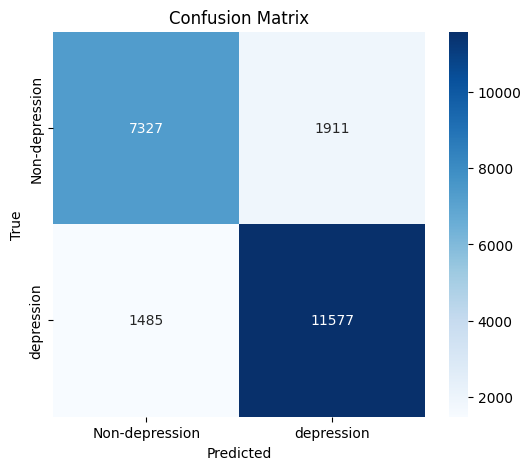

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      9238
           1       0.86      0.89      0.87     13062

    accuracy                           0.85     22300
   macro avg       0.84      0.84      0.84     22300
weighted avg       0.85      0.85      0.85     22300



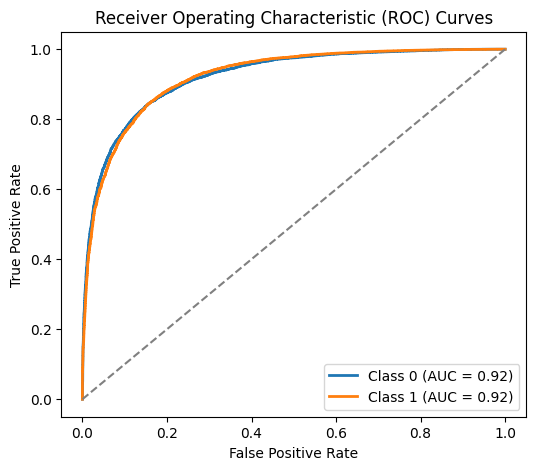

Affichage de la courbe d'apprentissage pour LogisticRegression...


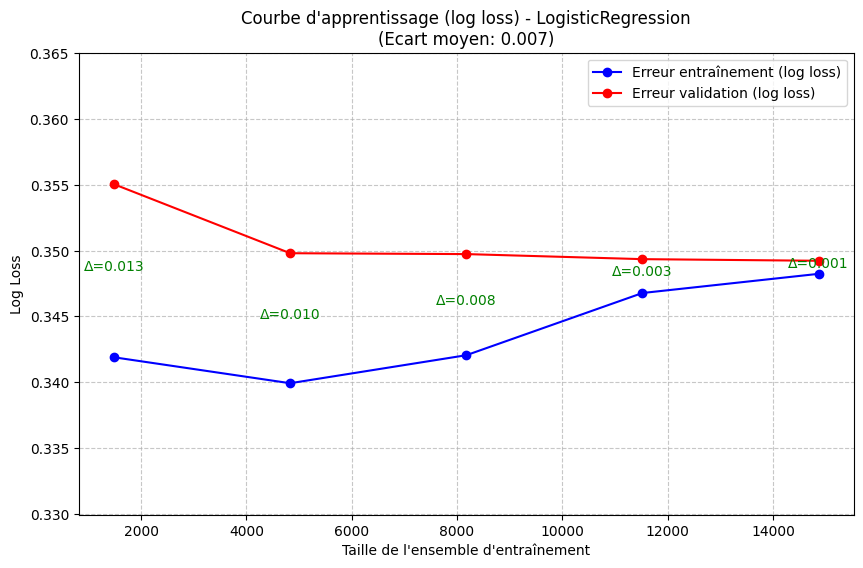

--------------------------------------------------
--- Entraînement et évaluation pour RandomForestClassifier ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs paramètres pour RandomForestClassifier: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Meilleur score (Accuracy CV) pour RandomForestClassifier: 0.8435
Durée de GridSearchCV pour RandomForestClassifier: 10.71 secondes
Meilleur modèle RandomForestClassifier sauvegardé dans saved_models/best_RandomForestClassifier_model_student_depression.joblib
Évaluation du meilleur modèle RandomForestClassifier sur l'ensemble d'entraînement :
Accuracy: 0.8850



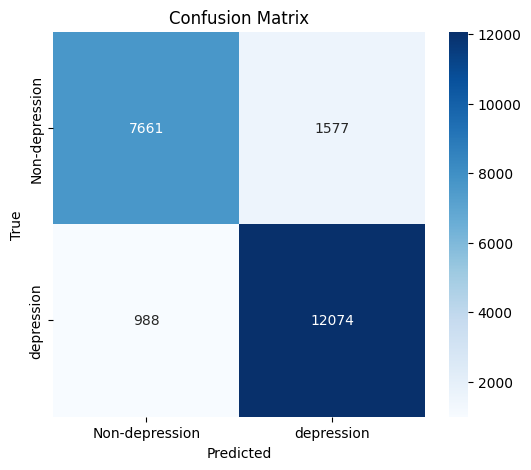

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      9238
           1       0.88      0.92      0.90     13062

    accuracy                           0.88     22300
   macro avg       0.89      0.88      0.88     22300
weighted avg       0.89      0.88      0.88     22300



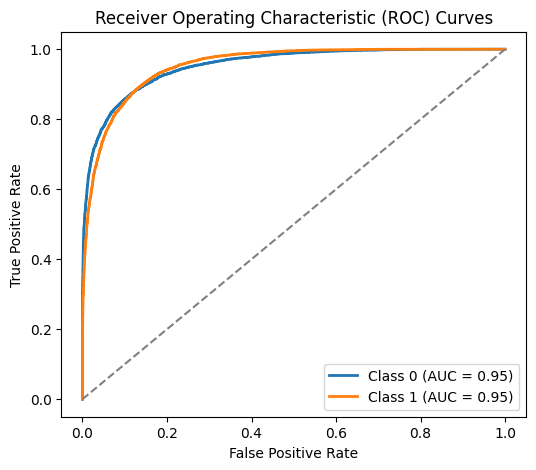

Affichage de la courbe d'apprentissage pour RandomForestClassifier...


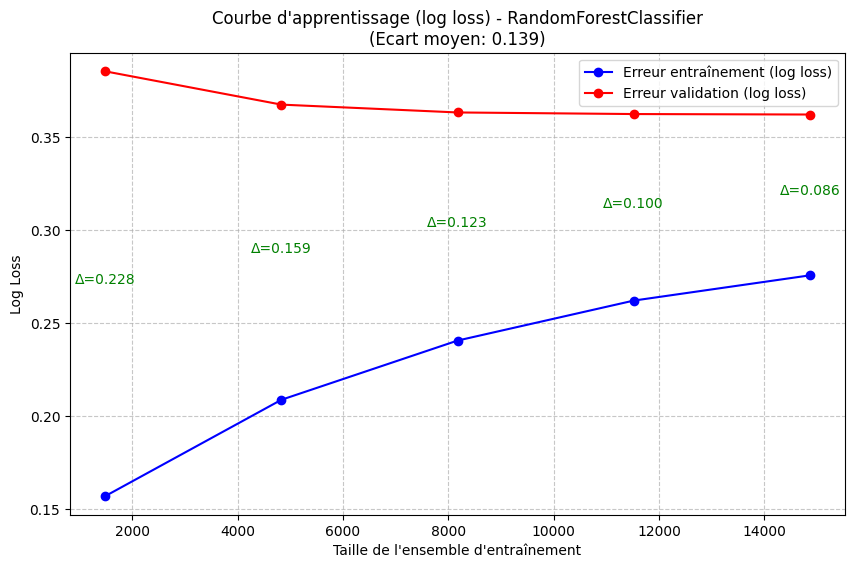

--------------------------------------------------
--- Entraînement et évaluation pour SVC ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleurs paramètres pour SVC: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Meilleur score (Accuracy CV) pour SVC: 0.8472
Durée de GridSearchCV pour SVC: 524.34 secondes
Meilleur modèle SVC sauvegardé dans saved_models/best_SVC_model_student_depression.joblib
Évaluation du meilleur modèle SVC sur l'ensemble d'entraînement :
Accuracy: 0.8504



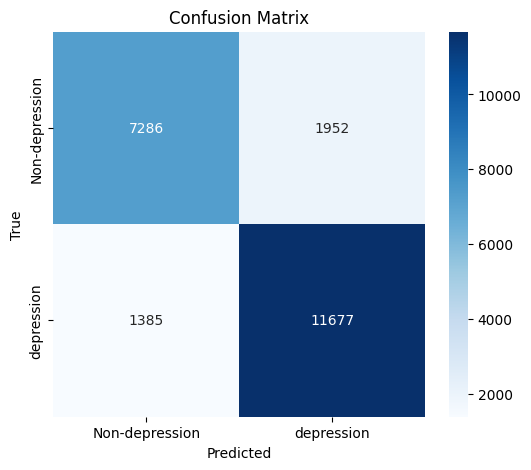

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      9238
           1       0.86      0.89      0.87     13062

    accuracy                           0.85     22300
   macro avg       0.85      0.84      0.84     22300
weighted avg       0.85      0.85      0.85     22300



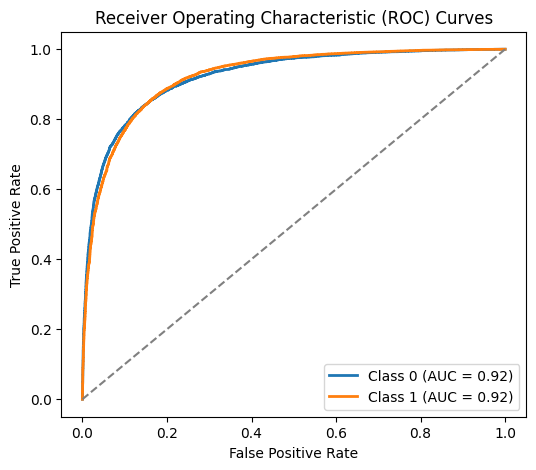

Affichage de la courbe d'apprentissage pour SVC...


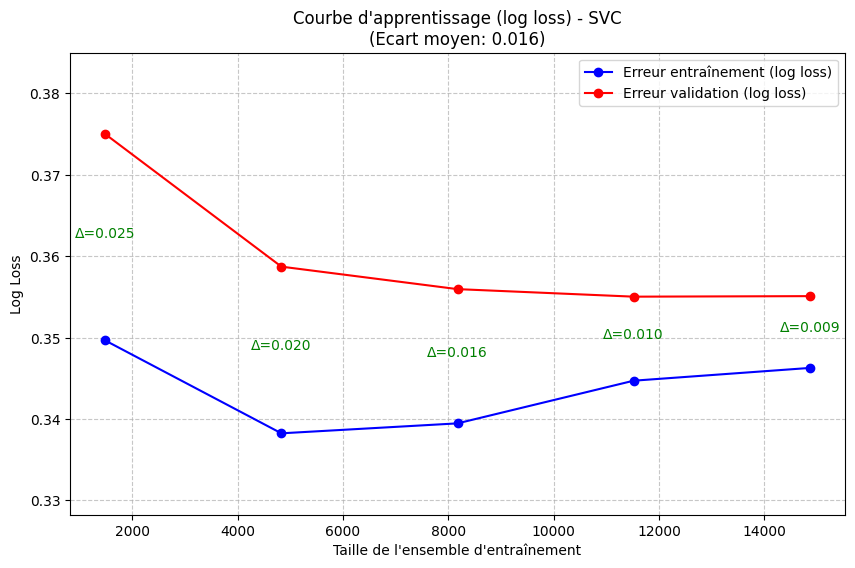

--------------------------------------------------
--- Entraînement et évaluation pour XGBoost ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\melom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning:

[22:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Meilleurs paramètres pour XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Meilleur score (Accuracy CV) pour XGBoost: 0.8470
Durée de GridSearchCV pour XGBoost: 20.95 secondes
Meilleur modèle XGBoost sauvegardé dans saved_models/best_XGBoost_model_student_depression.joblib
Évaluation du meilleur modèle XGBoost sur l'ensemble d'entraînement :
Accuracy: 0.8558



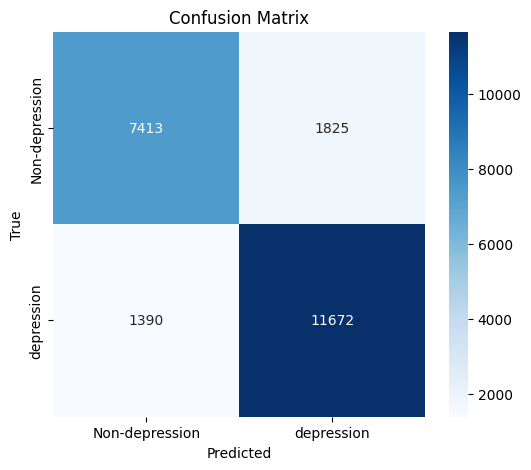

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      9238
           1       0.86      0.89      0.88     13062

    accuracy                           0.86     22300
   macro avg       0.85      0.85      0.85     22300
weighted avg       0.86      0.86      0.86     22300



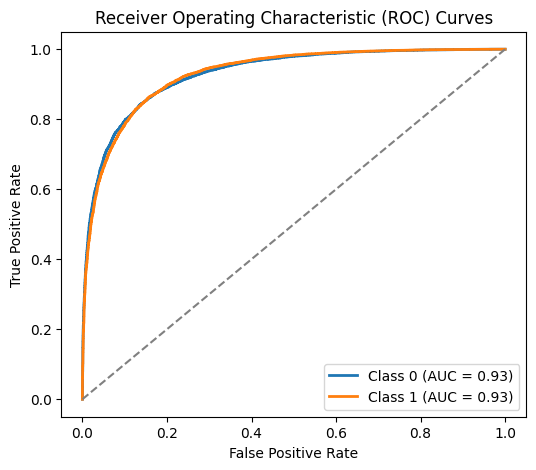

Affichage de la courbe d'apprentissage pour XGBoost...


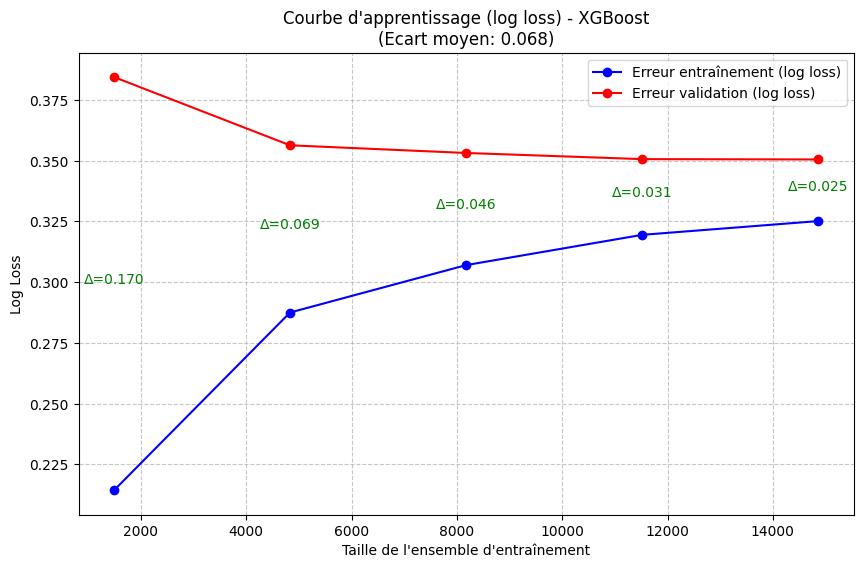

--------------------------------------------------
--- Entraînement et évaluation pour LightGBM ---
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 13062, number of negative: 9238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 22300, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585740 -> initscore=0.346382
[LightGBM] [Info] Start training from score 0.346382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\melom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

C:\Users\melom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Accuracy: 0.8512



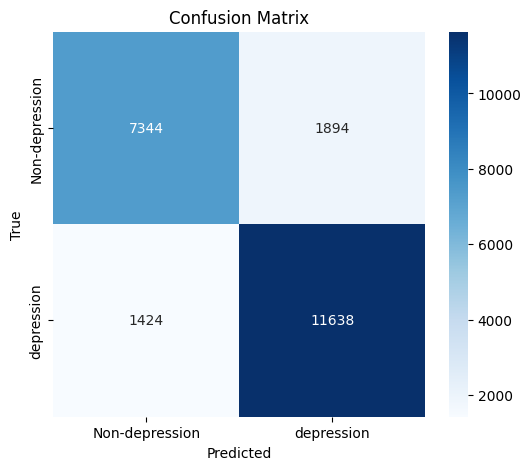

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      9238
           1       0.86      0.89      0.88     13062

    accuracy                           0.85     22300
   macro avg       0.85      0.84      0.85     22300
weighted avg       0.85      0.85      0.85     22300



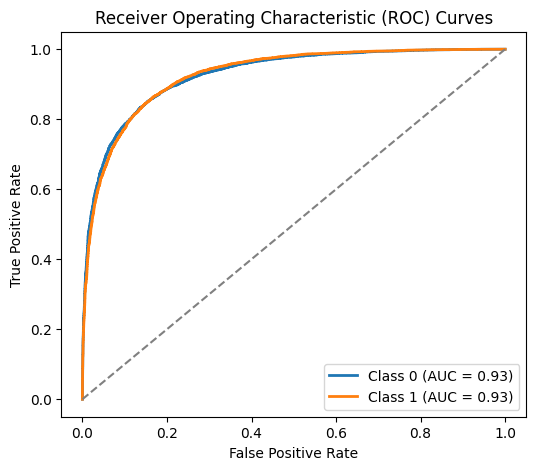

Affichage de la courbe d'apprentissage pour LightGBM...


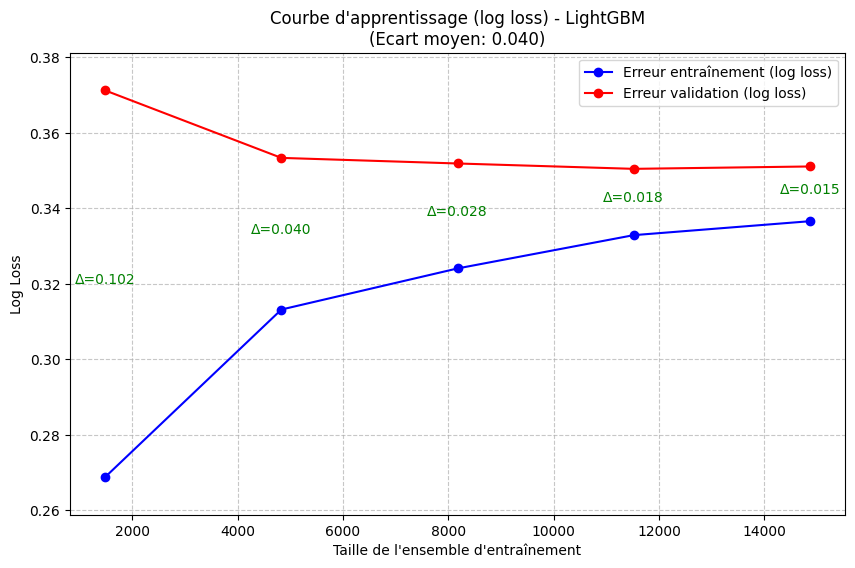

--------------------------------------------------
--- Entraînement et évaluation pour HistGradientBoosting ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres pour HistGradientBoosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 100, 'classifier__min_samples_leaf': 20}
Meilleur score (Accuracy CV) pour HistGradientBoosting: 0.8457
Durée de GridSearchCV pour HistGradientBoosting: 16.92 secondes
Meilleur modèle HistGradientBoosting sauvegardé dans saved_models/best_HistGradientBoosting_model_student_depression.joblib
Évaluation du meilleur modèle HistGradientBoosting sur l'ensemble d'entraînement :
Accuracy: 0.8643



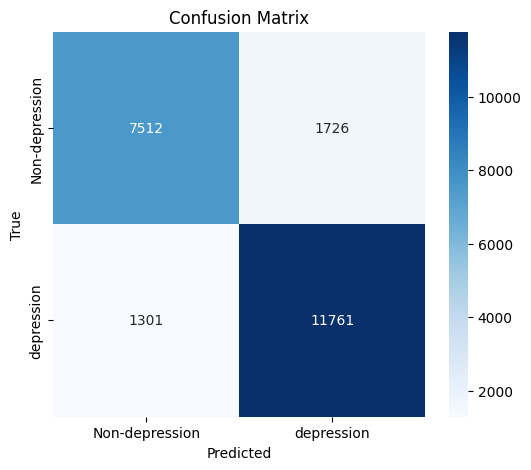

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      9238
           1       0.87      0.90      0.89     13062

    accuracy                           0.86     22300
   macro avg       0.86      0.86      0.86     22300
weighted avg       0.86      0.86      0.86     22300



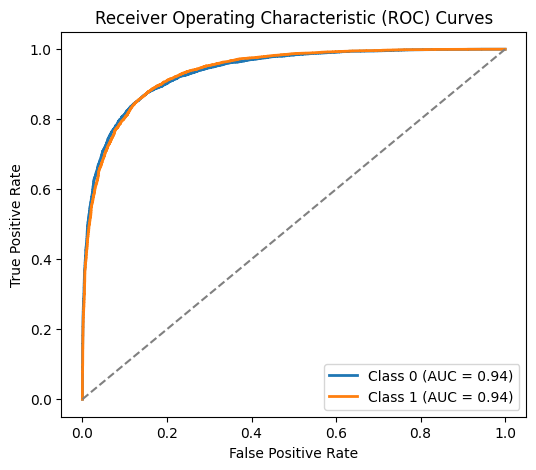

Affichage de la courbe d'apprentissage pour HistGradientBoosting...


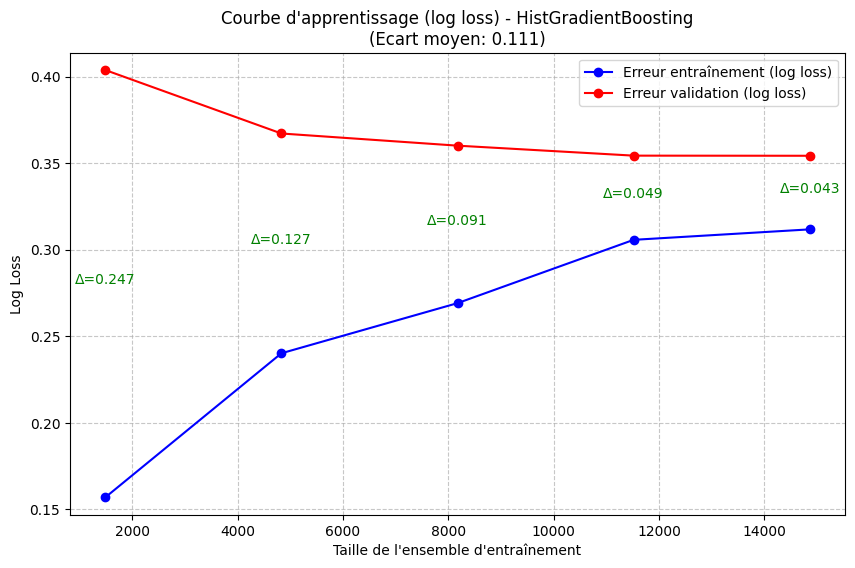

--------------------------------------------------

Entraînement terminé pour tous les modèles.


In [ ]:


if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

results = {}
best_estimators = {}

def train_evaluate_save_model(model_name, model, params, X_train, y_train, preprocessor):
    """
    Entraîne, évalue avec GridSearchCV, sauvegarde le meilleur modèle et retourne les résultats.
    """
    start_time = time.time()
    print(f"--- Entraînement et évaluation pour {model_name} ---")

    # Créer le pipeline: prétraitement + classifieur
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Définir la grille de paramètres pour le pipeline
    param_grid = {key: val for key, val in params.items()}
 
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    duration = end_time - start_time

    print(f"Meilleurs paramètres pour {model_name}: {grid_search.best_params_}")
    print(f"Meilleur score (Accuracy CV) pour {model_name}: {grid_search.best_score_:.4f}")
    print(f"Durée de GridSearchCV pour {model_name}: {duration:.2f} secondes")

    
    best_model_pipeline = grid_search.best_estimator_
    model_filename = f"saved_models/best_{model_name}_model_student_depression.joblib" # Nom de fichier spécifique
    joblib.dump(best_model_pipeline, model_filename)
    print(f"Meilleur modèle {model_name} sauvegardé dans {model_filename}")

    
    results[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_,
        'duration': duration,
        'model_filename': model_filename
    }
    best_estimators[model_name] = best_model_pipeline # Stocker le pipeline entraîné

   
    print(f"Évaluation du meilleur modèle {model_name} sur l'ensemble d'entraînement :")
    y_pred = best_model_pipeline.predict(X_train)
 
    if hasattr(best_model_pipeline, "predict_proba"):
        y_probs = best_model_pipeline.predict_proba(X_train)
    else:
        y_probs = None

    evaluate_model(X_train, y_train, y_pred, y_probs)

       
    print(f"Affichage de la courbe d'apprentissage pour {model_name}...")
    plot_learning_curve(best_model_pipeline, X_train, y_train, model_name=model_name, cv=3)




    print("-" * 50)
    return results, best_estimators

for model_name, model in models.items():
    results, best_estimators = train_evaluate_save_model(model_name, model, params[model_name], X_train, y_train, preprocessor)

print("\nEntraînement terminé pour tous les modèles.")

### Visualisation donnees apres nettoyage et traitement

In [ ]:


# Définir le meilleur modèle basé sur le score le plus élevé dans le dictionnaire 'results'
if 'results' in locals():
    best_model_name = max(results, key=lambda model: results[model]['best_score'])
    print(f"Meilleur modèle sélectionné : {best_model_name}")
else:
    raise ValueError("Le dictionnaire 'results' n'est pas défini. Veuillez exécuter les cellules précédentes.")

# Assurez-vous que les variables best_model_name, best_estimators, X_test, y_test existent
# Elles sont normalement définies après l'exécution des Cellules 10 et 11.

# Récupérer le meilleur pipeline entraîné depuis le dictionnaire
# Ou charger le modèle sauvegardé si vous préférez (optionnel)
if 'best_estimators' in locals() and best_model_name in best_estimators:
    best_pipeline = best_estimators[best_model_name]
    print(f"Utilisation du pipeline '{best_model_name}' stocké en mémoire.")
else:
    # Alternative: Charger depuis le fichier si 'best_estimators' n'est pas disponible
    try:
        model_filename = f"saved_models/best_{best_model_name}_model_student_depression.joblib"
        best_pipeline = joblib.load(model_filename)
        print(f"Chargement du pipeline '{best_model_name}' depuis le fichier {model_filename}.")
    except Exception as e:
        print(f"Erreur : Impossible de trouver ou charger le meilleur modèle '{best_model_name}'. Veuillez exécuter les cellules précédentes.")
        best_pipeline = None

if best_pipeline:
    # 1. Faire les prédictions sur l'ensemble de test
    y_pred_best = best_pipeline.predict(X_test)

    # 2. Calculer l'accuracy (juste pour rappel)
    accuracy_best = accuracy_score(y_test, y_pred_best)

    # 3. Générer le rapport de classification
    # Utiliser target_names pour des étiquettes claires (0: Non-Depression, 1: Depression)
    report_best = classification_report(y_test, y_pred_best, target_names=['Non-Depression', 'Depression'])

    # 4. Afficher le rapport
    print(f"\n--- Rapport de Classification pour le Meilleur Modèle ({best_model_name}) ---")
    print(f"Accuracy sur le test set: {accuracy_best:.4f}")
    print("\nRapport détaillé:")
    print(report_best)
else:
    print("Le pipeline du meilleur modèle n'a pas pu être chargé ou trouvé.")

Meilleur modèle sélectionné : SVC
Utilisation du pipeline 'SVC' stocké en mémoire.

--- Rapport de Classification pour le Meilleur Modèle (SVC) ---
Accuracy sur le test set: 0.8495

Rapport détaillé:
                precision    recall  f1-score   support

Non-Depression       0.84      0.79      0.81      2309
    Depression       0.86      0.89      0.87      3266

      accuracy                           0.85      5575
     macro avg       0.85      0.84      0.84      5575
  weighted avg       0.85      0.85      0.85      5575



Génération des visualisations pour le dataset prétraité...


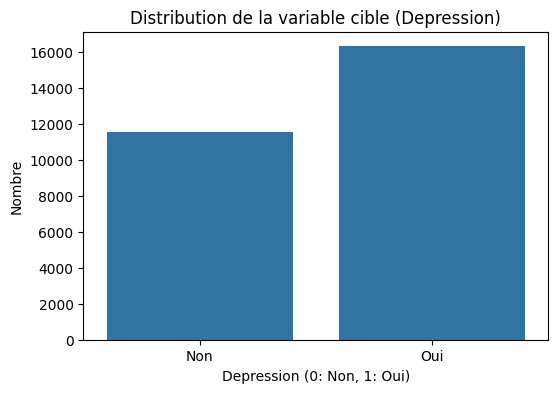


Histogrammes pour: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


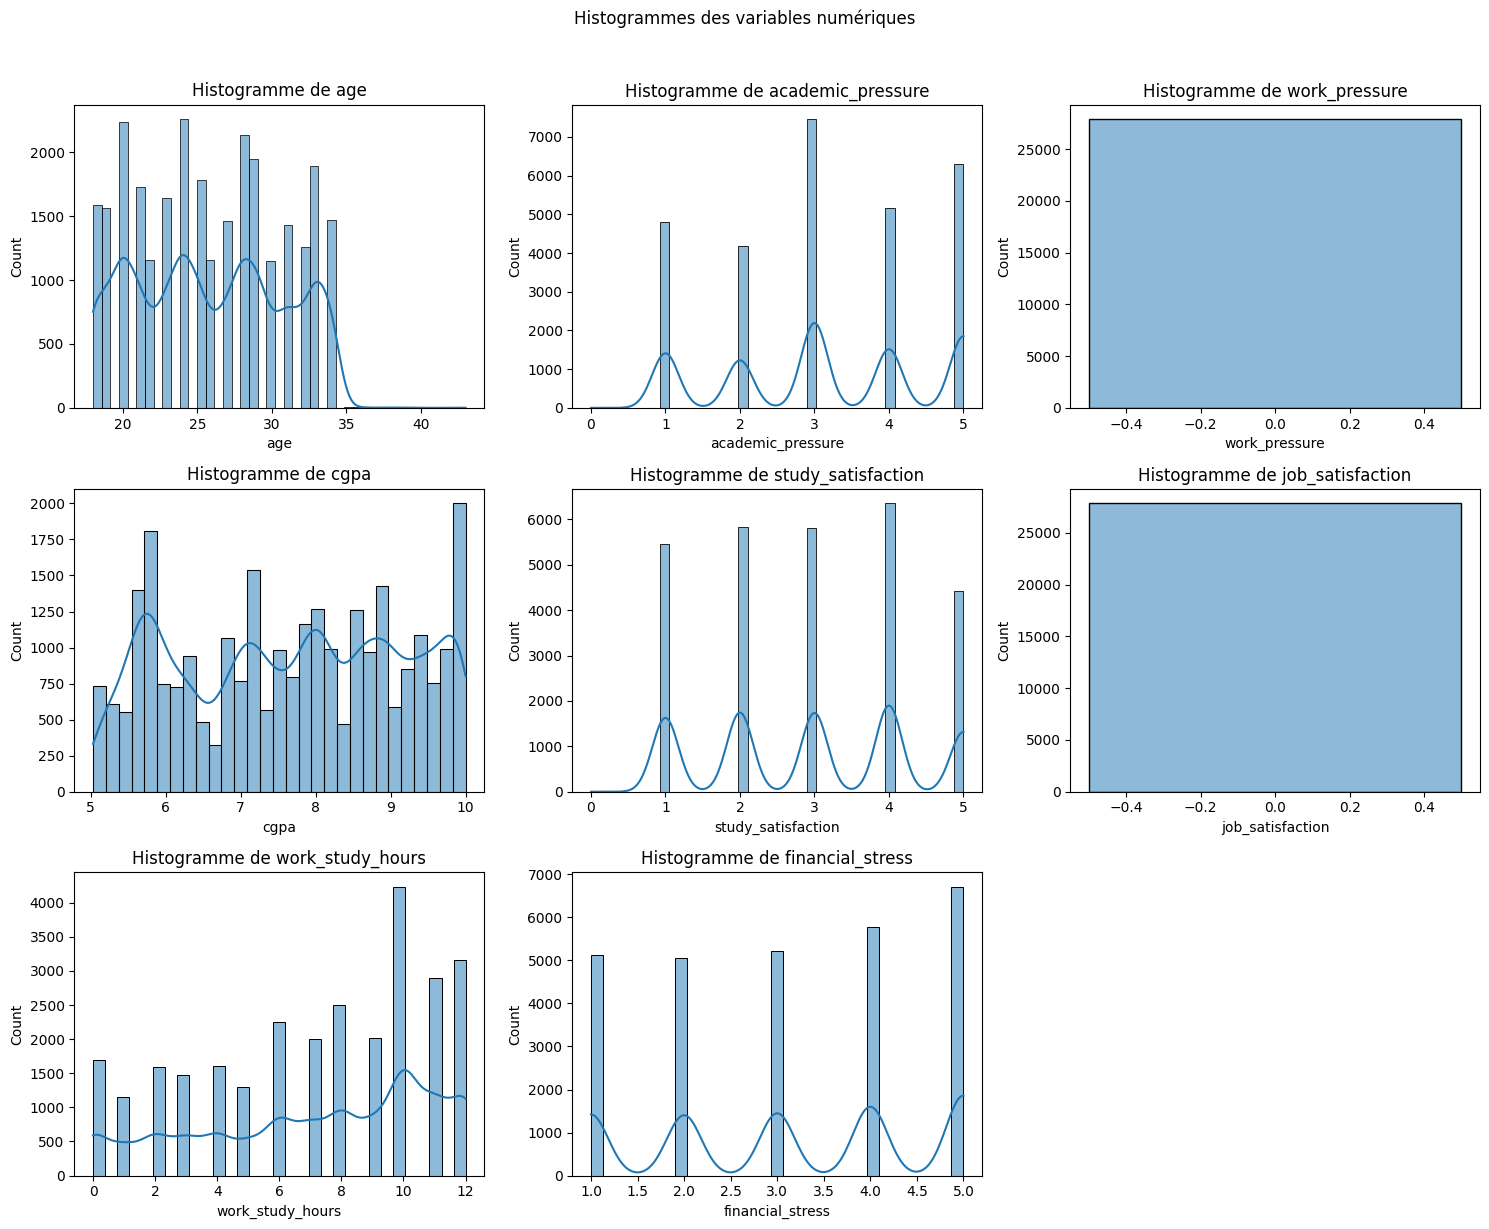


Boxplots pour: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


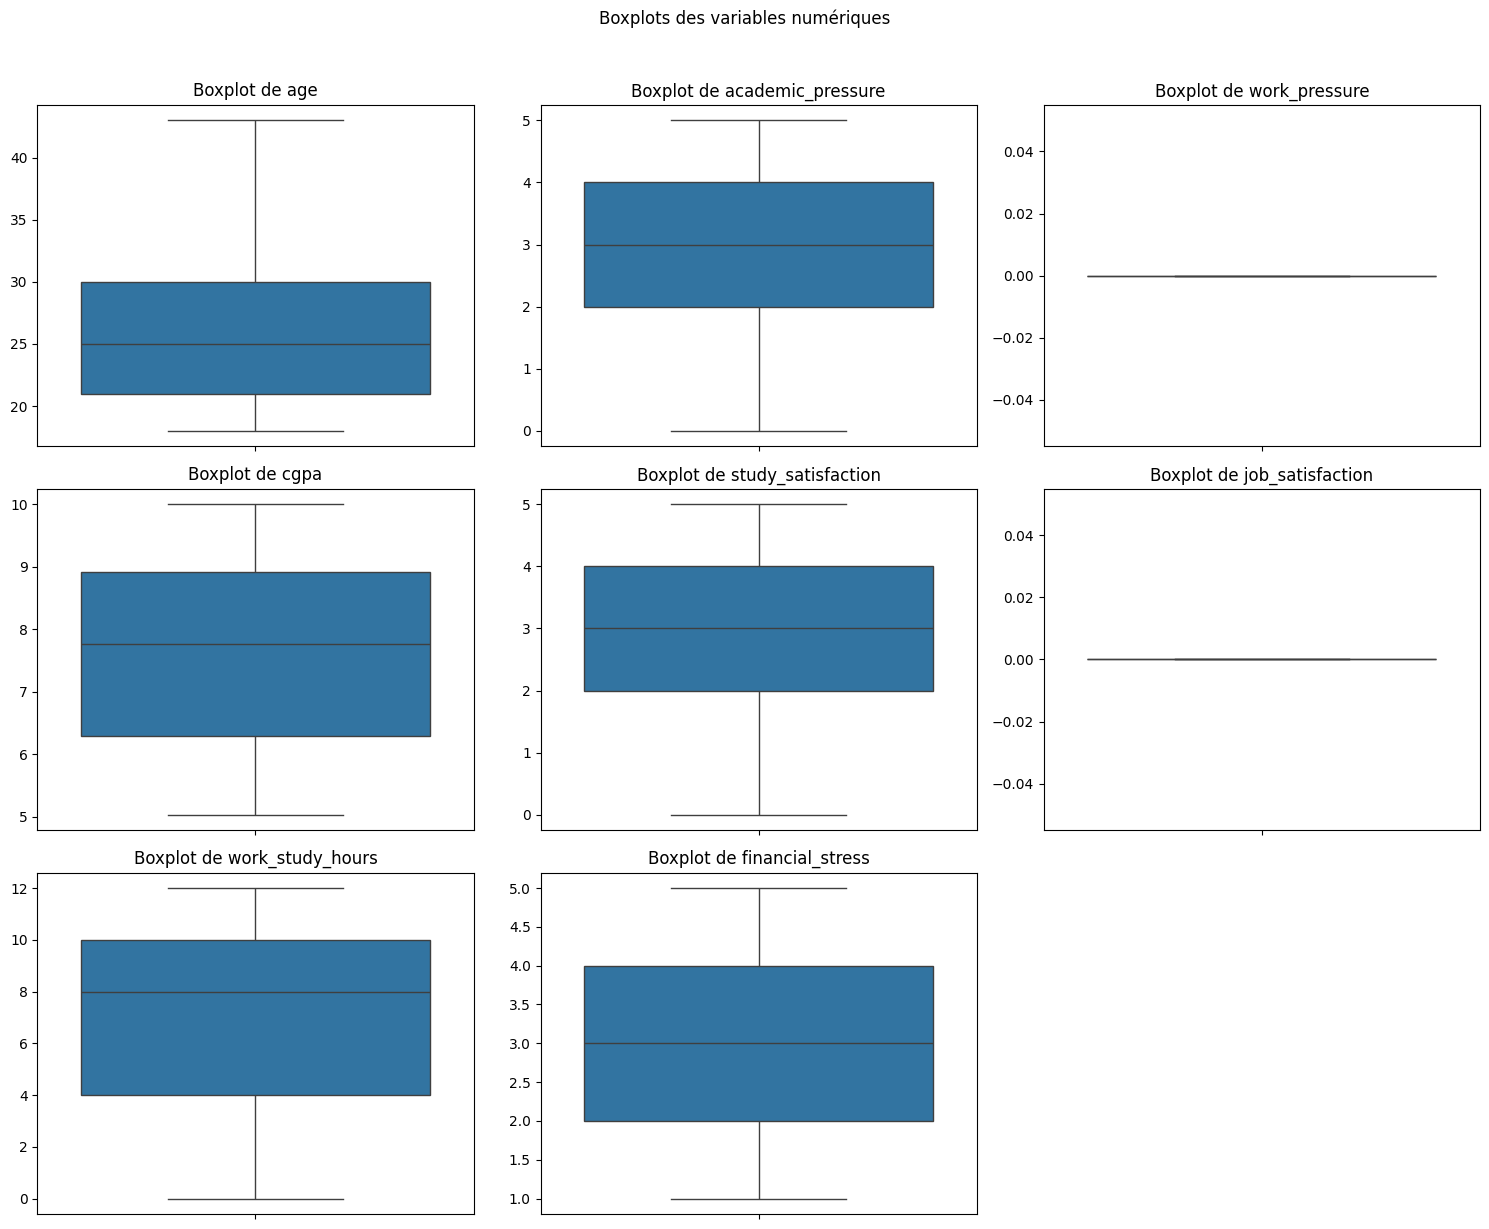


Diagrammes à barres pour: ['gender', 'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']


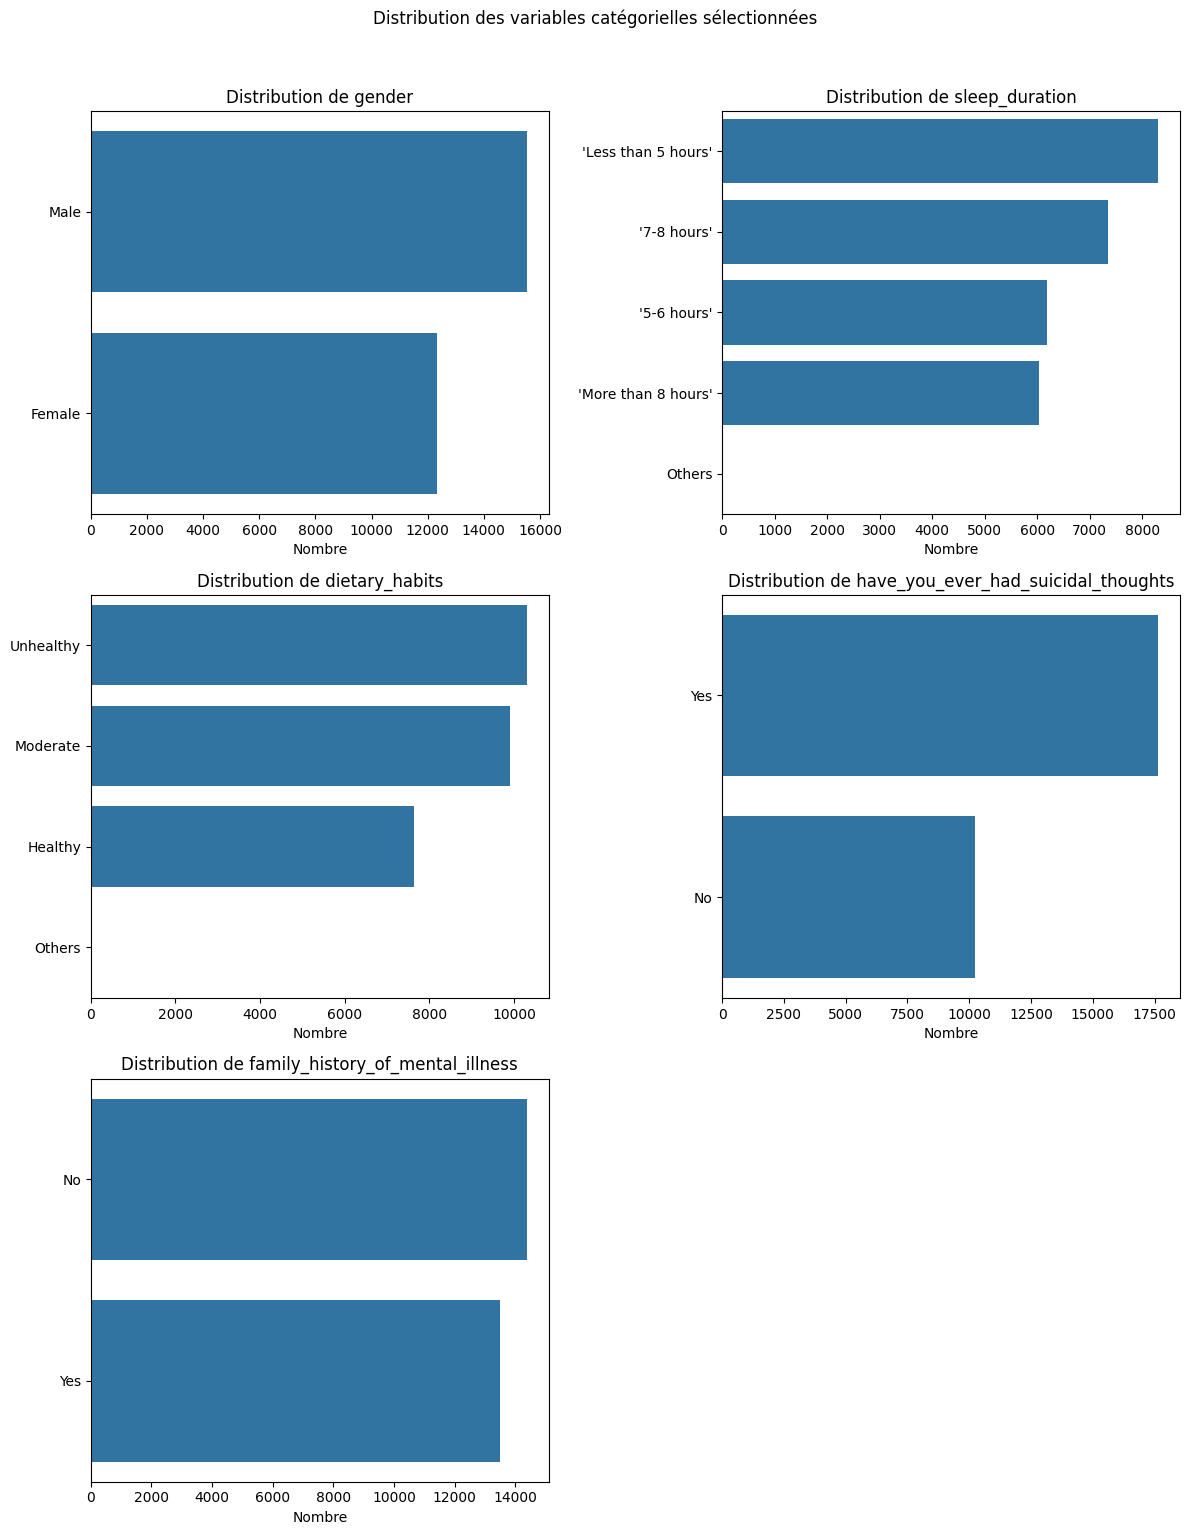


Heatmap de Corrélation des variables numériques:


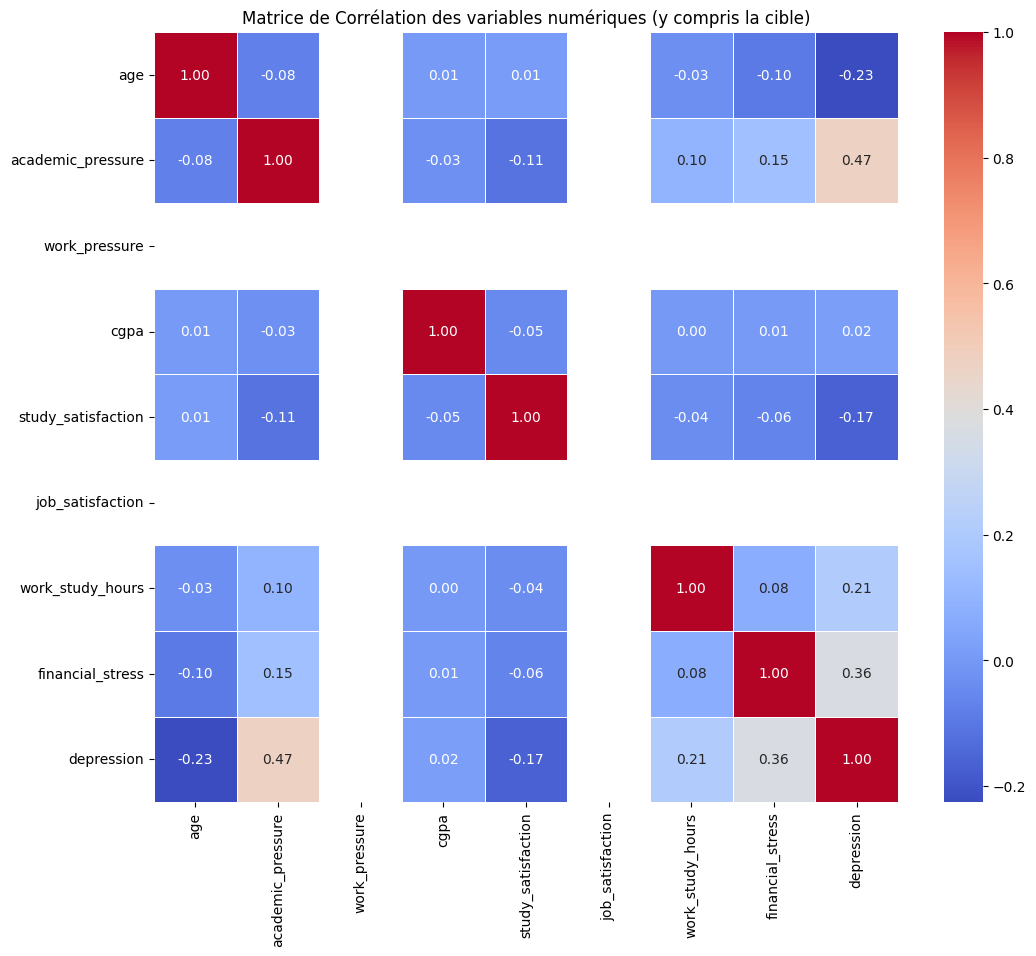


--- Fin des Visualisations ---


In [ ]:

# Assurez-vous que df_processed est le DataFrame nettoyé issu de la Cellule 4
if 'df_processed' not in locals():
    print("Erreur : Le DataFrame 'df_processed' n'a pas été trouvé. Veuillez exécuter la cellule de prétraitement (Cellule 4) d'abord.")
else:
    print("Génération des visualisations pour le dataset prétraité...")

    # --- Distribution de la variable cible ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x='depression', data=df_processed)
    plt.title('Distribution de la variable cible (Depression)')
    plt.xlabel('Depression (0: Non, 1: Oui)')
    plt.ylabel('Nombre')
    plt.xticks([0, 1], ['Non', 'Oui'])
    plt.show()

    # --- Histogrammes pour les variables numériques ---
    numerical_cols_plot = df_processed.select_dtypes(include=np.number).columns.tolist()
    if 'depression' in numerical_cols_plot:
        numerical_cols_plot.remove('depression') # Exclure la cible des histogrammes/boxplots séparés

    print(f"\nHistogrammes pour: {numerical_cols_plot}")
    n_cols_hist = 3 # Nombre de colonnes pour l'affichage des histogrammes
    n_rows_hist = (len(numerical_cols_plot) + n_cols_hist - 1) // n_cols_hist # Calculer le nombre de lignes nécessaires
    fig_hist, axes_hist = plt.subplots(n_rows_hist, n_cols_hist, figsize=(15, 4 * n_rows_hist))
    axes_hist = axes_hist.flatten() # Aplatir pour itérer facilement

    for i, col in enumerate(numerical_cols_plot):
        sns.histplot(df_processed[col], kde=True, ax=axes_hist[i])
        axes_hist[i].set_title(f'Histogramme de {col}')
    # Cacher les axes vides s'il y en a
    for j in range(i + 1, len(axes_hist)):
        fig_hist.delaxes(axes_hist[j])

    plt.suptitle('Histogrammes des variables numériques', y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Boxplots pour les variables numériques ---
    print(f"\nBoxplots pour: {numerical_cols_plot}")
    n_cols_box = 3 # Nombre de colonnes pour l'affichage des boxplots
    n_rows_box = (len(numerical_cols_plot) + n_cols_box - 1) // n_cols_box # Calculer le nombre de lignes nécessaires
    fig_box, axes_box = plt.subplots(n_rows_box, n_cols_box, figsize=(15, 4 * n_rows_box))
    axes_box = axes_box.flatten() # Aplatir pour itérer facilement

    for i, col in enumerate(numerical_cols_plot):
        sns.boxplot(y=df_processed[col], ax=axes_box[i])
        axes_box[i].set_title(f'Boxplot de {col}')
        axes_box[i].set_ylabel('') # Optionnel: enlever le nom de la colonne comme ylabel

    # Cacher les axes vides s'il y en a
    for j in range(i + 1, len(axes_box)):
        fig_box.delaxes(axes_box[j])

    plt.suptitle('Boxplots des variables numériques', y=1.02)
    plt.tight_layout()
    plt.show()


    # --- Bar charts (Countplots) pour les variables catégorielles importantes ---
    categorical_cols_plot = ['gender', 'sleep_duration', 'dietary_habits',
                             'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']
    # Filtrer au cas où une colonne n'existerait pas dans df_processed
    categorical_cols_plot = [col for col in categorical_cols_plot if col in df_processed.columns]

    print(f"\nDiagrammes à barres pour: {categorical_cols_plot}")
    n_cols_cat = 2 # Nombre de colonnes pour l'affichage
    n_rows_cat = (len(categorical_cols_plot) + n_cols_cat - 1) // n_cols_cat
    fig_cat, axes_cat = plt.subplots(nrows=n_rows_cat, ncols=n_cols_cat, figsize=(12, 5 * n_rows_cat)) # Ajuster la disposition
    axes_cat = axes_cat.flatten() # Aplatir

    for i, col in enumerate(categorical_cols_plot):
        sns.countplot(y=col, data=df_processed, ax=axes_cat[i], order = df_processed[col].value_counts().index)
        axes_cat[i].set_title(f'Distribution de {col}')
        axes_cat[i].set_xlabel('Nombre')
        axes_cat[i].set_ylabel('') # Enlever le nom de colonne comme ylabel

    # Cacher les axes vides
    for j in range(i + 1, len(axes_cat)):
        fig_cat.delaxes(axes_cat[j])

    plt.suptitle('Distribution des variables catégorielles sélectionnées', y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Matrice de corrélation (Heatmap) ---
    print("\nHeatmap de Corrélation des variables numériques:")
    plt.figure(figsize=(12, 10))
    # Inclure la cible 'depression' si elle est numérique pour voir ses corrélations
    numerical_cols_corr = df_processed.select_dtypes(include=np.number).columns.tolist()
    if not numerical_cols_corr:
        print("Aucune colonne numérique trouvée pour la matrice de corrélation.")
    else:
        correlation_matrix = df_processed[numerical_cols_corr].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matrice de Corrélation des variables numériques (y compris la cible)')
        plt.show()

    print("\n--- Fin des Visualisations ---")